# Dataset Selection


For this project, I have selected the 2025 MILK10k dataset from the International Skin Imaging Collaboration (ISIC).

MILK study team. MILK10k. ISIC Archive, 2025, doi:10.34970/648456.
https://challenge.isic-archive.com/data/#milk10k


Dataset Overview:

Samples: 10,480 images corresponding to 5,240 lesions.
It means that for one lesions there are two images.
**A clinical close-up photograph.** and 
**A dermatoscopic image.**

Each images has their own meta data with the following features:

        -age_approx
        -sex
        -skin_tone_class
        -site
        -MONET_ulceration_crust
        -MONET_hair
        -MONET_vasculature_vessels
        -MONET_erythema
        -MONET_pigmented
        -MONET_gel_water_drop_fluid_dermoscopy_liquid
        -MONET_skin_markings_pen_ink_purple_pen

Each lesions are label across 11 categories. That are :

        Actinic keratosis / intraepidermal carcinoma (AKIEC)
        Basal cell carcinoma (BCC)
        Other benign proliferations, including collision tumors (BEN_OTH)
        Benign keratinocytic lesion (BKL)
        Dermatofibroma (DF)
        Inflammatory and infectious conditions (INF)
        Other malignant proliferations, including collision tumors (MAL_OTH)
        Melanoma (MEL)
        Melanocytic nevus (NV)
        Squamous cell carcinoma / keratoacanthoma (SCCKA)
        Vascular lesions and hemorrhage (VASC)


# Preprocessing

Several preprocessing steps are necessary to prepare the dataset for model training:  

1. **Data Structuring**  
   - The raw dataset is provided as a ZIP archive containing lesion folders.  
   - Each folder has two images and a metadata file (`MILK10k_Training_Metadata.csv`).  
   - Another file (`MILK10k_Training_GroundTruth.csv`) provides lesion labels.  
   - Data needs to be joined by **lesion_id** to ensure correct mapping between metadata, images, and labels.  

2. **Handling Missing Data**  
   - Some lesions have missing metadata (≈ 51 lesion IDs).  
   - These rows must be removed to ensure clean inputs.  

3. **Feature Selection**  
   - Non-informative columns such as `lesion_id`, `image_type`, `isic_id`, `copyright_license`,  
     and `image_manipulation` are dropped.  

4. **Encoding Categorical Variables**  
   - `sex` and `site` are categorical, requiring **one-hot encoding**.  
   - All other MONET features are already numeric (binary indicators).  

5. **Scaling**  
   - Continuous features (`age_approx`, `skin_tone_class`, and all one-hot encoded categorical variables)  
     are standardized using **StandardScaler** to bring them into a comparable range.  

Hence, we will be building a Custom Dataset to train our model


## Feature Usage in Model Development  

The cleaned and preprocessed features will be used as follows in model development:  

- **Demographic features** (`age_approx`, `sex`, `skin_tone_class`) provide patient background information relevant for risk stratification.  
- **Anatomical site (`site`)** helps distinguish lesions likely to occur in certain body regions.  
- **MONET features** capture clinical and dermoscopic characteristics of lesions (e.g., ulceration, pigmentation, erythema), which are strong predictors of malignancy.  
- After preprocessing, the dataset is entirely numeric and can be directly used in classical machine learning models such as **Support Vector Classifier (SVC)**, **Logistic Regression**, or **Naïve Bayes**.  
- For deep learning models, the **images** can be combined with the **metadata features** for multimodal classification.  

In summary, the features are structured, cleaned, encoded, and scaled so they can be effectively used to train multi-class classification models that predict the lesion category.  

In [1]:
import os
import zipfile
import requests
import pandas as pd
from pathlib import Path
import torch


# data_path = Path("Data/")
# image_path = data_path / "MILK10k_Training_Input"

# if image_path.is_dir():
#     print(f"{image_path} directory already exists... skipping download")
# else:
#     print(f"{image_path} does not exist, creating one...")
#     image_path.mkdir(parents=True, exist_ok=True)


# with open(data_path / "MILK10k_Training_Input.zip", "wb") as f:
#     request = requests.get("https://isic-archive.s3.amazonaws.com/challenges/milk10k/MILK10k_Training_Input.zip")
#     print("Downloading MILK10Input.zip")
#     f.write(request.content)
    
# with zipfile.ZipFile(data_path / "MILK10k_Training_Input.zip", "r") as zip_ref:
#     print("Unzipping Milk10K_Training_Input.zip")
#     zip_ref.extractall(image_path)
    

    
    

# Data Exploration and Processing for the meta data

In [2]:
meta_data_path = "MILK10k_Training_Metadata.csv"
                
df = pd.read_csv(meta_data_path) 


# Check if there are any missing values
print("Any missing values? ->", df.isnull().values.any())

# Count missing values per column
print("\nMissing values per column:")
print(df.isnull().sum())

# Optionally: show only rows with missing values
missing_rows = df[df.isnull().any(axis=1)]
print("\nRows with missing values:")
print(missing_rows)

missing_rows.nunique()


Any missing values? -> True

Missing values per column:
lesion_id                                        0
image_type                                       0
isic_id                                          0
attribution                                      0
copyright_license                                0
image_manipulation                               0
age_approx                                      40
sex                                              0
skin_tone_class                                  0
site                                            62
MONET_ulceration_crust                           0
MONET_hair                                       0
MONET_vasculature_vessels                        0
MONET_erythema                                   0
MONET_pigmented                                  0
MONET_gel_water_drop_fluid_dermoscopy_liquid     0
MONET_skin_markings_pen_ink_purple_pen           0
dtype: int64

Rows with missing values:
        lesion_id          image_type

lesion_id                                        51
image_type                                        2
isic_id                                         102
attribution                                       1
copyright_license                                 1
image_manipulation                                2
age_approx                                       12
sex                                               2
skin_tone_class                                   6
site                                              4
MONET_ulceration_crust                          102
MONET_hair                                      102
MONET_vasculature_vessels                       102
MONET_erythema                                  102
MONET_pigmented                                 102
MONET_gel_water_drop_fluid_dermoscopy_liquid    102
MONET_skin_markings_pen_ink_purple_pen          102
dtype: int64

From checking the nunique value of the missing rows, we can find that there are 51 unique lesion_id, from where we can conclude that when we assign the meta data to the lesion images there will be 51 unique lesion without one or both its meta data. We need to remember this number to check if we have the right amount of lesion after we remove the lesion with missing meta data


In [3]:
df = df.dropna()


# Check if there are any missing values
print("Any missing values? ->", df.isnull().values.any())

# Count missing values per column
print("\nMissing values per column:")
print(df.isnull().sum())

df.info()



Any missing values? -> False

Missing values per column:
lesion_id                                       0
image_type                                      0
isic_id                                         0
attribution                                     0
copyright_license                               0
image_manipulation                              0
age_approx                                      0
sex                                             0
skin_tone_class                                 0
site                                            0
MONET_ulceration_crust                          0
MONET_hair                                      0
MONET_vasculature_vessels                       0
MONET_erythema                                  0
MONET_pigmented                                 0
MONET_gel_water_drop_fluid_dermoscopy_liquid    0
MONET_skin_markings_pen_ink_purple_pen          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 10378 entries, 0 to 10479
Data colu

Nice, we have removed all the rows with missing values, now we can have a look at the unique datas we have

In [4]:
df.head()

lesion_id          image_type       isic_id      attribution  \
0  IL_0000652  clinical: close-up  ISIC_8149219  MILK study team   
1  IL_0000652         dermoscopic  ISIC_4671410  MILK study team   
2  IL_0003176  clinical: close-up  ISIC_3904045  MILK study team   
3  IL_0003176         dermoscopic  ISIC_5371928  MILK study team   
4  IL_0004688  clinical: close-up  ISIC_0791494  MILK study team   

  copyright_license image_manipulation  age_approx     sex  skin_tone_class  \
0          CC-BY-NC            altered        70.0    male                1   
1          CC-BY-NC    instrument only        70.0    male                1   
2          CC-BY-NC    instrument only        45.0  female                5   
3          CC-BY-NC    instrument only        45.0  female                5   
4          CC-BY-NC    instrument only        50.0    male                3   

              site  MONET_ulceration_crust  MONET_hair  \
0   head_neck_face                0.166749    0.163601   
1   head_neck_face                0.659859    0.156478   
2   head_neck_face                0.348609    0.614718   
3   head_neck_face                0.392950    0.897668   
4  lower_extremity                0.889925    0.120788   

   MONET_vasculature_vessels  MONET_erythema  MONET_pigmented  \
0                   0.002284        0.124315         0.719495   
1                   0.016397        0.032357         0.847014   
2                   0.013415        0.447485         0.061977   
3                   0.367882        0.645776         0.122108   
4                   0.004546        0.487298         0.036550   

   MONET_gel_water_drop_fluid_dermoscopy_liquid  \
0                                      0.220399   
1                                      0.138121   
2                                      0.296341   
3                                      0.719937   
4                                      0.146776   

   MONET_skin_markings_pen_ink_purple_pen  
0                                0.237601  
1                                0.148776  
2                                0.058006  
3                                0.329812  
4                                0.086027

Since, we will be dropping lesion_id, image_type, isic_id, copyright_license, image_manipulation, we dont have to any encoding to turn the data from categorical to continous data. However, we will be converting the *sex* and the *site* features to continuous data by using a one hot encoder.

In [5]:
from sklearn.preprocessing import OneHotEncoder

# Columns to one-hot encode
categorical_cols = ["sex", "site"]

encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(df[categorical_cols])

encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))



# Replace categorical columns with encoded ones
df = df.drop(columns=categorical_cols)
df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

print("Processed DataFrame shape:", df.shape)
print(df.head())

Processed DataFrame shape: (10378, 24)
    lesion_id          image_type       isic_id      attribution  \
0  IL_0000652  clinical: close-up  ISIC_8149219  MILK study team   
1  IL_0000652         dermoscopic  ISIC_4671410  MILK study team   
2  IL_0003176  clinical: close-up  ISIC_3904045  MILK study team   
3  IL_0003176         dermoscopic  ISIC_5371928  MILK study team   
4  IL_0004688  clinical: close-up  ISIC_0791494  MILK study team   

  copyright_license image_manipulation  age_approx  skin_tone_class  \
0          CC-BY-NC            altered        70.0                1   
1          CC-BY-NC    instrument only        70.0                1   
2          CC-BY-NC    instrument only        45.0                5   
3          CC-BY-NC    instrument only        45.0                5   
4          CC-BY-NC    instrument only        50.0                3   

   MONET_ulceration_crust  MONET_hair  ...  \
0                0.166749    0.163601  ...   
1                0.659859    0.15

Now, we have converted the required data into continuous data to be fit into the model, although some models that we are going to test doesnot require any categorical to continuous transforamtion, its easier when we do need that. Now we are going to scale the data. 

In [6]:
# Grab all columns (everything is numeric now, after one-hot encoding)
all_features = df.columns.tolist()
print("All feature columns:", all_features)


All feature columns: ['lesion_id', 'image_type', 'isic_id', 'attribution', 'copyright_license', 'image_manipulation', 'age_approx', 'skin_tone_class', 'MONET_ulceration_crust', 'MONET_hair', 'MONET_vasculature_vessels', 'MONET_erythema', 'MONET_pigmented', 'MONET_gel_water_drop_fluid_dermoscopy_liquid', 'MONET_skin_markings_pen_ink_purple_pen', 'sex_female', 'sex_male', 'site_foot', 'site_genital', 'site_hand', 'site_head_neck_face', 'site_lower_extremity', 'site_trunk', 'site_upper_extremity']


In [7]:
from sklearn.preprocessing import StandardScaler

features_to_scale = [
    "age_approx",
    "skin_tone_class",
]


scaler = StandardScaler()


df_scaled = df.copy()
df_scaled[features_to_scale] = scaler.fit_transform(df[features_to_scale])

print("Scaled dataset shape:", df_scaled.shape)
print(df_scaled.head())


Scaled dataset shape: (10378, 24)
    lesion_id          image_type       isic_id      attribution  \
0  IL_0000652  clinical: close-up  ISIC_8149219  MILK study team   
1  IL_0000652         dermoscopic  ISIC_4671410  MILK study team   
2  IL_0003176  clinical: close-up  ISIC_3904045  MILK study team   
3  IL_0003176         dermoscopic  ISIC_5371928  MILK study team   
4  IL_0004688  clinical: close-up  ISIC_0791494  MILK study team   

  copyright_license image_manipulation  age_approx  skin_tone_class  \
0          CC-BY-NC            altered    0.549254        -2.775969   
1          CC-BY-NC    instrument only    0.549254        -2.775969   
2          CC-BY-NC    instrument only   -1.049040         2.250904   
3          CC-BY-NC    instrument only   -1.049040         2.250904   
4          CC-BY-NC    instrument only   -0.729381        -0.262533   

   MONET_ulceration_crust  MONET_hair  ...  \
0                0.166749    0.163601  ...   
1                0.659859    0.156478 

Since we removed  some of the lesion from the train data we have to remove the same lesion from the text data.

In [8]:
df_scaled.dtypes

lesion_id                                        object
image_type                                       object
isic_id                                          object
attribution                                      object
copyright_license                                object
image_manipulation                               object
age_approx                                      float64
skin_tone_class                                 float64
MONET_ulceration_crust                          float64
MONET_hair                                      float64
MONET_vasculature_vessels                       float64
MONET_erythema                                  float64
MONET_pigmented                                 float64
MONET_gel_water_drop_fluid_dermoscopy_liquid    float64
MONET_skin_markings_pen_ink_purple_pen          float64
sex_female                                      float64
sex_male                                        float64
site_foot                                       

In [9]:
rmv_lesion_id = missing_rows.iloc[:,0]
rmv_lesion_id.head()


36     IL_0029019
37     IL_0029019
490    IL_0444889
491    IL_0444889
740    IL_0697844
Name: lesion_id, dtype: object

In [10]:


lesion_label = pd.read_csv('MILK10k_Training_GroundTruth.csv')

lesion_label.info()
print(lesion_label.head())

# Filter out rows where lesion_id is in rmv_lesion_id
lesion_label = lesion_label[~lesion_label['lesion_id'].isin(rmv_lesion_id)]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5240 entries, 0 to 5239
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lesion_id  5240 non-null   object 
 1   AKIEC      5240 non-null   float64
 2   BCC        5240 non-null   float64
 3   BEN_OTH    5240 non-null   float64
 4   BKL        5240 non-null   float64
 5   DF         5240 non-null   float64
 6   INF        5240 non-null   float64
 7   MAL_OTH    5240 non-null   float64
 8   MEL        5240 non-null   float64
 9   NV         5240 non-null   float64
 10  SCCKA      5240 non-null   float64
 11  VASC       5240 non-null   float64
dtypes: float64(11), object(1)
memory usage: 491.4+ KB
    lesion_id  AKIEC  BCC  BEN_OTH  BKL   DF  INF  MAL_OTH  MEL   NV  SCCKA  \
0  IL_0000652    0.0  1.0      0.0  0.0  0.0  0.0      0.0  0.0  0.0    0.0   
1  IL_0003176    0.0  1.0      0.0  0.0  0.0  0.0      0.0  0.0  0.0    0.0   
2  IL_0004688    0.0  1.0      0.0  0.0  

In [11]:
lesion_label.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5189 entries, 0 to 5239
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lesion_id  5189 non-null   object 
 1   AKIEC      5189 non-null   float64
 2   BCC        5189 non-null   float64
 3   BEN_OTH    5189 non-null   float64
 4   BKL        5189 non-null   float64
 5   DF         5189 non-null   float64
 6   INF        5189 non-null   float64
 7   MAL_OTH    5189 non-null   float64
 8   MEL        5189 non-null   float64
 9   NV         5189 non-null   float64
 10  SCCKA      5189 non-null   float64
 11  VASC       5189 non-null   float64
dtypes: float64(11), object(1)
memory usage: 527.0+ KB


Here we could see that we have the correct number of lesion labels. Now we are going to do some analysis on the label data to see if have equal distribution of label across different classes

Class counts:
 AKIEC       303.0
BCC        2518.0
BEN_OTH      43.0
BKL         541.0
DF           52.0
INF          49.0
MAL_OTH       9.0
MEL         444.0
NV          712.0
SCCKA       473.0
VASC         45.0
dtype: float64

Percentage distribution:
 AKIEC       5.839275
BCC        48.525728
BEN_OTH     0.828676
BKL        10.425901
DF          1.002120
INF         0.944305
MAL_OTH     0.173444
MEL         8.556562
NV         13.721334
SCCKA       9.115437
VASC        0.867219
dtype: float64


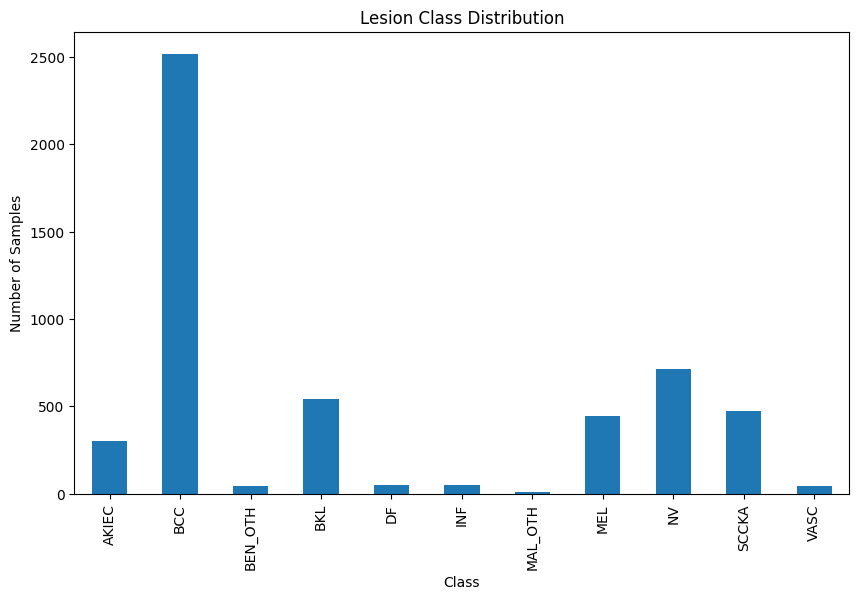

In [12]:
import matplotlib.pyplot as plt

# Drop lesion_id, sum the rest to get counts per class
class_counts = lesion_label.drop(columns=["lesion_id"]).sum()

# Print counts
print("Class counts:\n", class_counts)

# Print percentage distribution
print("\nPercentage distribution:\n", (class_counts / class_counts.sum()) * 100)

# Bar plot
class_counts.plot(
    kind='bar',
    figsize=(10,6),
    title="Lesion Class Distribution"
)
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()



### Conclusion
Theres are huge imbalance in the class distrubution, as shown above. This could impact the performance model. however, for the current implementation , i will be keeping the imbalance in the distrubution of the classes.

In [90]:
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms


class Milk10KDataset(Dataset):
    def __init__(self, meta_data, label_data = None, image_root = None, transform=None):
        """
        meta_data: DataFrame containing 'isic_id', 'image_type', and metadata fields
        label_data: DataFrame with 'lesion_id' and label columns
        image_root: Path to image directory
        """
        self.samples = []
        self.transform = transform

        before_count = len(meta_data)
        removed_count = 0

        # Labels as numpy
        if label_data:
            self.y = np.argmax(np.array(label_data.iloc[:, 1:]), axis=1)
        else:
            self.y = np.zeros(len(meta_data))
        
        
        self.label_name = ['AKIEC','BCC','BEN_OTH','BKL','DF','INF','MAL_OTH','MEL','NV','SCCKA','VASC']



        # Build dataset sample list
        for idx, lesion_id in enumerate(meta_data["lesion_id"]):
            lesion_path = os.path.join(image_root, lesion_id)

            # Skip missing folders
            if not os.path.exists(lesion_path):
                print(f"⚠ Lesion folder missing: {lesion_id}")
                removed_count += 1
                continue

            image_files = os.listdir(lesion_path)
            if len(image_files) != 2:
                print(f"⚠ Lesion {lesion_id} has {len(image_files)} images (expected 2)")
                removed_count += 1
                continue

            # Paths for both images
            img1_path = os.path.join(lesion_path, image_files[0])
            img2_path = os.path.join(lesion_path, image_files[1])
            img1_id = image_files[0].replace(".jpg", "")
            img2_id = image_files[1].replace(".jpg", "")

            # Get metadata for both images
            img1_meta = self._get_metadata(meta_data, img1_id)
            img2_meta = self._get_metadata(meta_data, img2_id)

            # Remove lesion if any metadata invalid
            if not self._is_metadata_valid(img1_meta) or not self._is_metadata_valid(img2_meta):
                removed_count += 1
                continue

            # Determine which is clinical vs dermoscopic
            if img1_meta[0] == "clinical: close-up":
                clinical_path, clinical_meta = img1_path, torch.tensor(img1_meta[1:].astype(np.float32), dtype=torch.float32)
                dermo_path, dermo_meta = img2_path, torch.tensor(img2_meta[1:].astype(np.float32), dtype=torch.float32)
            else:
                clinical_path, clinical_meta = img2_path, torch.tensor(img2_meta[1:].astype(np.float32), dtype=torch.float32)
                dermo_path, dermo_meta = img1_path, torch.tensor(img1_meta[1:].astype(np.float32), dtype=torch.float32)

            # Add valid sample
            self.samples.append({
                "lesion_id": lesion_id,
                "clinical_path": clinical_path,
                "dermo_path": dermo_path,
                "clinical_meta": clinical_meta,
                "dermo_meta": dermo_meta,
                "label": torch.tensor(self.y[idx], dtype=torch.float32)
            })



    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        clinical_img = Image.open(sample["clinical_path"]).convert("RGB").resize((256, 256))
        dermo_img = Image.open(sample["dermo_path"]).convert("RGB").resize((256, 256))

        # To tensor
        clinical_img = transforms.ToTensor()(clinical_img)
        dermo_img = transforms.ToTensor()(dermo_img)

        if self.transform:
            clinical_img = self.transform(clinical_img)
            dermo_img = self.transform(dermo_img)

        return (
            clinical_img,
            dermo_img,
            sample["clinical_meta"],
            sample["dermo_meta"],
            sample["label"]
        )

    def _get_metadata(self, meta_data, image_id):
        row = meta_data.loc[meta_data["isic_id"] == image_id]
        if row.empty:
            return None

        selected_features = [
            "image_type",
            "age_approx",
            "skin_tone_class",
            "MONET_ulceration_crust",
            "MONET_hair",
            "MONET_vasculature_vessels",
            "MONET_erythema",
            "MONET_pigmented",
            "MONET_gel_water_drop_fluid_dermoscopy_liquid",
            "MONET_skin_markings_pen_ink_purple_pen",
            "sex_female",
            "sex_male",
            "site_foot",
            "site_genital",
            "site_hand",
            "site_head_neck_face",
            "site_lower_extremity",
            "site_trunk",
            "site_upper_extremity",
        ]
        return np.array(row.iloc[0][selected_features].values, dtype=object)

    def _is_metadata_valid(self, meta):
        if meta is None:
            return False
        # Skip if any value is None or NaN (excluding first element = image_type)
        if any(x is None or (isinstance(x, float) and np.isnan(x)) for x in meta[1:]):
            return False
        return True



In [14]:
img_path = "Data\MILK10k_Training_Input\MILK10k_Training_Input"

data = Milk10KDataset(df_scaled, lesion_label, img_path)

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\kinle\AppData\Local\Temp\ipykernel_5564\1471052967.py:1: SyntaxWarning: invalid escape sequence '\M'
  img_path = "Data\MILK10k_Training_Input\MILK10k_Training_Input"


From here we can conclude that all the meta data have been assign to the right image id since after removing lesion without one or both its meta data we can see that the amount of lesion that has been removed from the dataset by subtracting the **Before cleaning: 5240 lesions** with **After cleaning: 5189 lesions** that difference up to 51 lesion. And if we refer back to the conclusion from the meta data exploration, we can see the number of removed lesion is equal to the unique lesion with missing meta data.


In [86]:
data.label_name

['AKIEC',
 'BCC',
 'BEN_OTH',
 'BKL',
 'DF',
 'INF',
 'MAL_OTH',
 'MEL',
 'NV',
 'SCCKA',
 'VASC']

In [16]:
from PIL import Image
import matplotlib.pyplot as plt
import random

def show_lesions(dataset, n=5):
    """
    Display the first n lesions from a dataset that returns image file paths.

    Args:
        dataset: PyTorch dataset instance. __getitem__ should return
                 (clinical_image_path, derm_image_path, meta_data) or dict
        n (int): number of lesions to show
    """
    for i in range(min(n, len(dataset))):
        
        rd = random.randint(0, len(dataset) - 1)
        
        sample = dataset.samples[rd]

        # Unpack sample
        if isinstance(sample, dict):
            clinical_path = sample.get("clinical_path")
            print(clinical_path)
            derm_path = sample.get("dermo_path")
            clinical_meta = sample.get("clinical_meta")
            dermo_meta = sample.get("dermo_meta")
        elif isinstance(sample, (list, tuple)):
            clinical_path, derm_path, meta = sample[:3]
        else:
            raise TypeError("Dataset __getitem__ must return tuple/list or dict.")

        # Open images using PIL
        clinical_img = Image.open(clinical_path).convert("RGB")
        derm_img = Image.open(derm_path).convert("RGB")

        # Show clinical image
        print(f"Lesion {rd} - Clinical Image")
        plt.imshow(clinical_img)
        plt.axis('off')
        plt.show()
        print("Clinical metadata:")
        print(clinical_meta)
        print("-"*40)

        # Show dermoscopic image
        print(f"Lesion {rd} - Dermoscopic Image")
        plt.imshow(derm_img)
        plt.axis('off')
        plt.show()
        print("Dermoscopic metadata:")
        print(dermo_meta)
        print("="*60)


Data\MILK10k_Training_Input\MILK10k_Training_Input\IL_7047069\ISIC_9802702.jpg
Lesion 3644 - Clinical Image


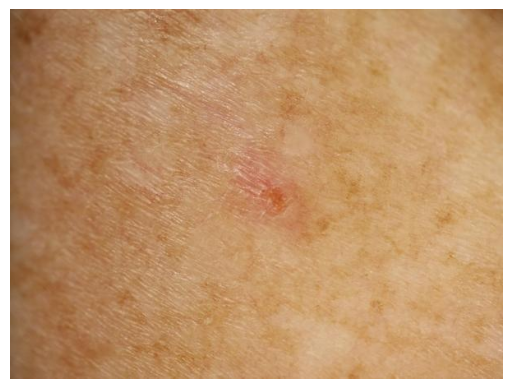

Clinical metadata:
tensor([-0.0901, -0.2625,  0.3921,  0.1017,  0.0078,  0.5978,  0.2303,  0.2089,
         0.1488,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         1.0000,  0.0000])
----------------------------------------
Lesion 3644 - Dermoscopic Image


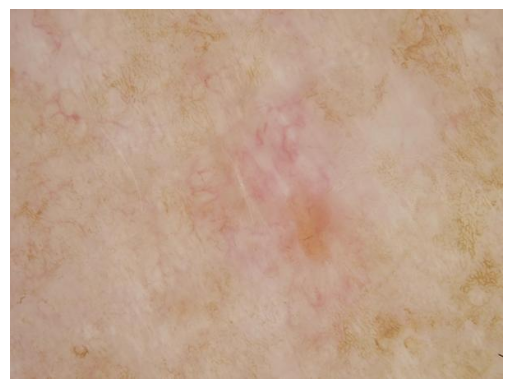

Dermoscopic metadata:
tensor([-0.0901, -0.2625,  0.2260,  0.2533,  0.1039,  0.3241,  0.1825,  0.1872,
         0.0280,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         1.0000,  0.0000])
Data\MILK10k_Training_Input\MILK10k_Training_Input\IL_8359841\ISIC_6033339.jpg
Lesion 4343 - Clinical Image


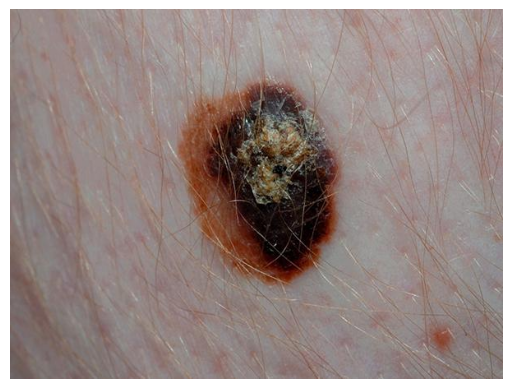

Clinical metadata:
tensor([-1.6884e+00, -2.6253e-01,  8.5454e-01,  1.2989e-01,  6.8981e-04,
         1.2019e-01,  6.7837e-01,  3.5193e-02,  3.0310e-01,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00])
----------------------------------------
Lesion 4343 - Dermoscopic Image


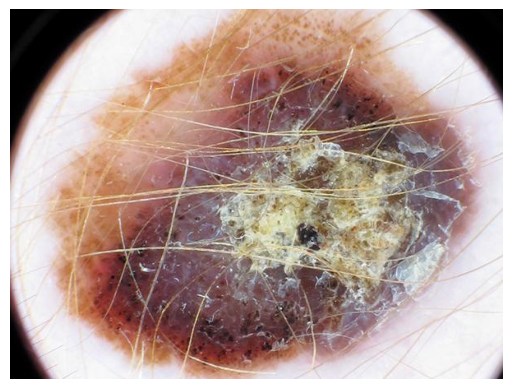

Dermoscopic metadata:
tensor([-1.6884, -0.2625,  0.8126,  0.2842,  0.0060,  0.1643,  0.4876,  0.0778,
         0.1095,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
         0.0000,  0.0000])
Data\MILK10k_Training_Input\MILK10k_Training_Input\IL_6719325\ISIC_6625754.jpg
Lesion 3488 - Clinical Image


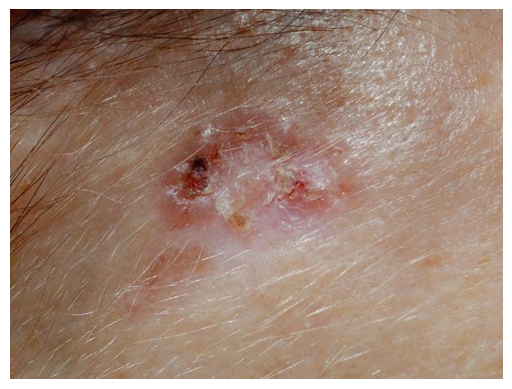

Clinical metadata:
tensor([-9.0064e-02, -2.6253e-01,  7.8167e-01,  7.7216e-02,  7.4473e-04,
         7.2865e-02,  2.7334e-02,  1.0371e-01,  2.7008e-02,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00])
----------------------------------------
Lesion 3488 - Dermoscopic Image


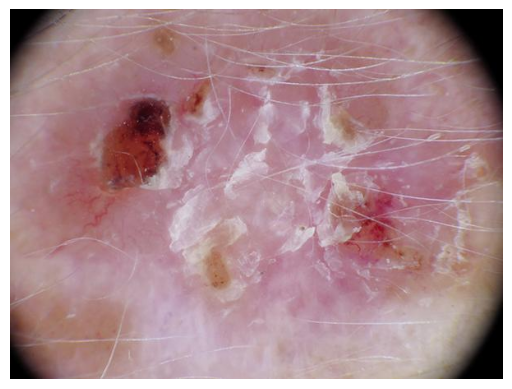

Dermoscopic metadata:
tensor([-0.0901, -0.2625,  0.7969,  0.2309,  0.1088,  0.4614,  0.2037,  0.2656,
         0.1858,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
         0.0000,  0.0000])
Data\MILK10k_Training_Input\MILK10k_Training_Input\IL_9471694\ISIC_8095870.jpg
Lesion 4917 - Clinical Image


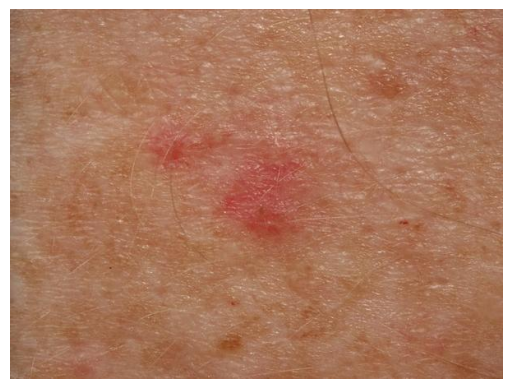

Clinical metadata:
tensor([-1.3687, -0.2625,  0.2990,  0.1771,  0.0525,  0.7822,  0.1630,  0.1878,
         0.1408,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         1.0000,  0.0000])
----------------------------------------
Lesion 4917 - Dermoscopic Image


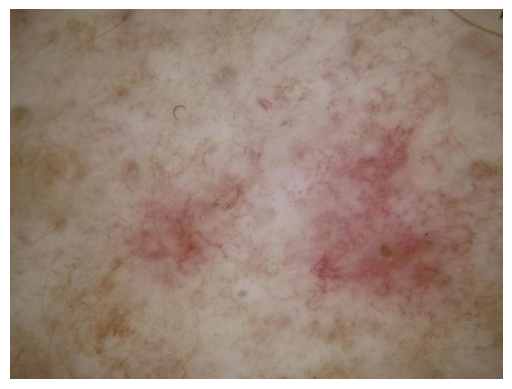

Dermoscopic metadata:
tensor([-1.3687, -0.2625,  0.0339,  0.2951,  0.3688,  0.5333,  0.2115,  0.1571,
         0.0720,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         1.0000,  0.0000])
Data\MILK10k_Training_Input\MILK10k_Training_Input\IL_7064564\ISIC_6932479.jpg
Lesion 3653 - Clinical Image


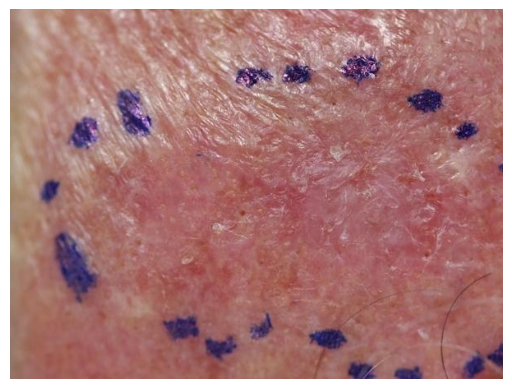

Clinical metadata:
tensor([0.5493, 0.9942, 0.0812, 0.1181, 0.0106, 0.1927, 0.0315, 0.1133, 0.3485,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000])
----------------------------------------
Lesion 3653 - Dermoscopic Image


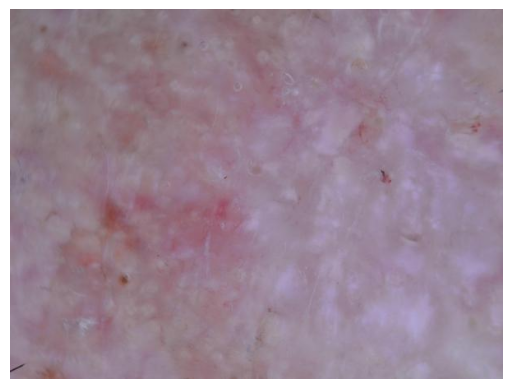

Dermoscopic metadata:
tensor([0.5493, 0.9942, 0.3167, 0.3215, 0.1250, 0.5663, 0.1348, 0.3433, 0.0806,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000])


In [17]:
show_lesions(data, n=5)

# Summary of Cleaned / Pre-Processed Data  

## Data Integration  
- Each **lesion** in the MILK10k dataset is represented by:  
  - A **clinical close-up image**  
  - A **dermatoscopic image**  
  - Associated **metadata features**  

- The custom dataset class (`Milk10K_Dataset`) ensures both images and metadata are loaded and aligned by `lesion_id`.  
- Each sample returns a **combined feature vector** consisting of:  
  - Flattened clinical image (grayscale, resized to 60×45 → 2,700 features)  
  - Flattened dermoscopic image (grayscale, resized to 60×45 → 2,700 features)  
  - Metadata features for clinical and dermoscopic images (≈ 18 features each)  
  - Final feature vector per lesion ≈ **5,436+ features**  

---

## Cleaning and Pre-Processing Steps  

1. **Image Pre-processing**  
   - Images are converted to **grayscale** (`convert('L')`).  
   - Resized to **60×45 pixels** to reduce dimensionality.  
   - Converted into tensors and flattened into 1D feature vectors.  

2. **Metadata Pre-processing**  
   - Selected features retained:  
     - `age_approx`, `skin_tone_class`  
     - Binary MONET features (ulceration, hair, pigmentation, etc.)  
     - One-hot encoded `sex` (`sex_female`, `sex_male`)  
     - One-hot encoded `site` (7 anatomical sites)  
   - All metadata stored as **NumPy arrays (float32)**.  
   - Missing values identified via `check_missing()` and removed using `remove_missing()`.  

3. **Handling Missing Data**  
   - Lesions without complete metadata or images are dropped.  
   - Cleaning step reduces dataset size slightly but ensures each lesion has full, consistent data.  

4. **Final Data Representation**  
   - Each lesion is represented by a **single, concatenated feature vector** combining:  
     - Clinical image features  
     - Dermoscopic image features  
     - Clinical metadata  
     - Dermoscopic metadata  
   - Labels are multi-class, represented as one-hot vectors for **11 lesion categories**.  

---

## Dataset Readiness for PRML Models  

- The dataset is now:  
  - **Numeric only** (images flattened + metadata vectors).  
  - **Consistent** (no missing data after cleaning).  
  - **Standardized** (via `StandardScaler` for metadata features).  
- Suitable for a variety of PRML models, including:  
  - **Classical ML**: Logistic Regression, SVC, Naïve Bayes.  
  - **Hybrid / multimodal approaches**: combining metadata with image-based models.  

✅ In summary, the dataset is structured as high-dimensional feature vectors with cleaned metadata and preprocessed images, fully ready for use in PRML model development.  


# Model Implementation with Cross Validation

The parameter's for the model were choosen via my own biasness

In [18]:
import torch
import torch.nn as nn

class MultiModalLesionNet(nn.Module):
    def __init__(self, input_size=3, hidden_unit=64, output_size=11, meta_data_dim=18, hidden_layer_DNN=2):
        super().__init__()
        
        # Clinical image branch
        self.clinical_conv = nn.Sequential(
            nn.Conv2d(input_size, hidden_unit, 3, 1, 0),
            nn.ReLU(),
            nn.Conv2d(hidden_unit, hidden_unit, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(hidden_unit, hidden_unit, 3, 1, 0),
            nn.ReLU(),
            nn.Conv2d(hidden_unit, hidden_unit, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        
        # Dermoscopic image branch
        self.dermo_conv = nn.Sequential(
            nn.Conv2d(input_size, hidden_unit, 3, 1, 0),
            nn.ReLU(),
            nn.Conv2d(hidden_unit, hidden_unit, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(hidden_unit, hidden_unit, 3, 1, 0),
            nn.ReLU(),
            nn.Conv2d(hidden_unit, hidden_unit, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        
        # Metadata MLP (dynamic)
        def build_meta_mlp(input_dim, hidden_unit, hidden_layer_DNN):
            layers = [nn.Linear(input_dim, hidden_unit), nn.ReLU()]
            for _ in range(hidden_layer_DNN - 1):
                layers.append(nn.Linear(hidden_unit, hidden_unit))
                layers.append(nn.ReLU())
            return nn.Sequential(*layers)
        
        self.clinical_meta_MLP = build_meta_mlp(meta_data_dim, hidden_unit, hidden_layer_DNN)
        self.dermo_meta_MLP = build_meta_mlp(meta_data_dim, hidden_unit, hidden_layer_DNN)
        
        # Learnable meta boost (soft attention)
        self.clinical_meta_boost = nn.Parameter(torch.ones(1))
        self.dermo_meta_boost = nn.Parameter(torch.ones(1))
        
        # Final image + meta FC
        # We'll calculate flattened conv output dynamically
        dummy = torch.zeros(1, input_size, 256, 256)
        clinical_feat_size = self.clinical_conv(dummy).shape[1]
        dermo_feat_size = self.dermo_conv(dummy).shape[1]
        
        self.clinical_fc = nn.Sequential(
            nn.Linear(clinical_feat_size + hidden_unit, hidden_unit),
            nn.ReLU(),
            nn.Linear(hidden_unit, output_size)
        )
        
        self.dermo_fc = nn.Sequential(
            nn.Linear(dermo_feat_size + hidden_unit, hidden_unit),
            nn.ReLU(),
            nn.Linear(hidden_unit, output_size)
        )
        
        # Final classifier combining both branches
        final_layers = [nn.Linear(output_size * 2, hidden_unit), nn.ReLU()]
        for _ in range(hidden_layer_DNN - 1):
            final_layers.append(nn.Linear(hidden_unit, hidden_unit))
            final_layers.append(nn.ReLU())
        final_layers.append(nn.Linear(hidden_unit, output_size))
        self.final_classifier = nn.Sequential(*final_layers)
        
    def forward(self, clinical_img, dermo_img, clinical_meta, dermo_meta):
        # Clinical branch
        c_feat = self.clinical_conv(clinical_img)
        c_meta = self.clinical_meta_MLP(clinical_meta)
        c = self.clinical_fc(torch.cat((c_feat, c_meta * self.clinical_meta_boost), dim=1))
        
        # Dermoscopic branch
        d_feat = self.dermo_conv(dermo_img)
        d_meta = self.dermo_meta_MLP(dermo_meta)
        d = self.dermo_fc(torch.cat((d_feat, d_meta * self.dermo_meta_boost), dim=1))
        
        # Final combination
        combined = torch.cat((c, d), dim=1)
        out = self.final_classifier(combined)
        return out


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



Using device: cuda


# DataLoader

In [20]:
from torch.utils.data import random_split

# Example: 80% train, 20% test
dataset_size = len(data)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(data, [train_size, test_size])

print(f"Total: {dataset_size}, Train: {len(train_dataset)}, Test: {len(test_dataset)}")


Total: 5189, Train: 4151, Test: 1038


In [21]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


In [26]:
import torch
from sklearn.metrics import f1_score, classification_report

def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    
    train_acc = 0
    train_loss = 0
    all_preds = []
    all_labels = []

    for batch, (cli_img, der_img, cli_meta_data, derm_meta_data, label) in enumerate(dataloader):
        cli_img, der_img, cli_meta_data, derm_meta_data, label = (
            cli_img.to(device),
            der_img.to(device),
            cli_meta_data.to(device),
            derm_meta_data.to(device),
            label.to(device)
        )

        # Forward pass
        y_pred = model(cli_img, der_img, cli_meta_data, derm_meta_data)
        loss = loss_fn(y_pred, label.long())
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Collect predictions and labels
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == label).sum().item()/len(y_pred)
        all_preds.extend(y_pred_class.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

    # Compute average loss and F1
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    print(f"\n=== 🏋️ Training Metrics ===")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Train Acc F1: {train_acc:.4f}\n")
    print("Per-Class F1 Scores:")
    print(classification_report(all_labels, all_preds, digits=4, zero_division=0))

    return train_loss, train_acc


def test_step(model, dataloader, loss_fn, device):
    model.eval()
    
    
    test_acc = 0
    test_loss = 0
    all_preds = []
    all_labels = []

    with torch.inference_mode():
        for batch, (cli_img, der_img, cli_meta_data, derm_meta_data, label) in enumerate(dataloader):
            cli_img, der_img, cli_meta_data, derm_meta_data, label = (
                cli_img.to(device),
                der_img.to(device),
                cli_meta_data.to(device),
                derm_meta_data.to(device),
                label.to(device)
            )

            # Forward pass
            y_pred = model(cli_img, der_img, cli_meta_data, derm_meta_data)
            loss = loss_fn(y_pred, label.long())
            test_loss += loss.item()
            
            
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == label).sum().item()/len(y_pred)
            all_preds.extend(y_pred_class.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    print(f"\n=== 🧪 Test Metrics ===")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Acc: {test_acc:.4f}\n")
    print("Per-Class F1 Scores:")
    print(classification_report(all_labels, all_preds, digits=4, zero_division=0 ))

    return test_loss, test_acc


In [57]:
from tqdm.auto import tqdm

def train(model, train_dataloader, test_dataloader = None, optimizer = None, loss_fn = nn.CrossEntropyLoss(), epochs = 5, device = device):
    
    
    results = {"train_loss": [],
               "train_acc": [],
 
               "test_loss": [],
               "test_acc": [],

               }


    for epoch in tqdm(range(epochs)):
        
        train_loss, train_acc = train_step(model = model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device
                                          )
        
        if test_dataloader:
            test_loss, test_acc = test_step(
                model=model,
                dataloader=test_dataloader,
                loss_fn=loss_fn,
                device=device
            )
        
        
        
        print(f"Epoch: {epoch + 1} | Train Loss: {train_loss:.4f}| Train Acc: {train_acc:.4f}")
        if test_dataloader:
            print(f"Epoch: {epoch + 1} Test Loss: {test_loss:.4f }| Test  Acc: {test_acc:.4f}")
            results["test_loss"].append(test_loss)
            results["test_acc"].append(test_acc)
        
        
        
        

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)

    return results
        


## Model 0 - Base Model

In [ ]:
NUM_EPOCHS = 50

model_0 = MultiModalLesionNet(
    input_size=3,
    hidden_unit=10,
    output_size=11,
    meta_data_dim=18,
    hidden_layer_DNN=10
).to(device)

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001,
                             )



from timeit import default_timer as timer

start_time = timer()


model_0_results = train(model=model_0,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        )

end_time = timer()

print(f"Total Training Time: {end_time - start_time}")


  0%|          | 0/50 [00:00<?, ?it/s]


=== 🏋️ Training Metrics ===
Train Loss: 2.0580
Train Acc F1: 0.4795

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       239
         1.0     0.4796    1.0000    0.6483      1991
         2.0     0.0000    0.0000    0.0000        36
         3.0     0.0000    0.0000    0.0000       429
         4.0     0.0000    0.0000    0.0000        48
         5.0     0.0000    0.0000    0.0000        39
         6.0     0.0000    0.0000    0.0000         7
         7.0     0.0000    0.0000    0.0000       361
         8.0     0.0000    0.0000    0.0000       590
         9.0     0.0000    0.0000    0.0000       375
        10.0     0.0000    0.0000    0.0000        36

    accuracy                         0.4796      4151
   macro avg     0.0436    0.0909    0.0589      4151
weighted avg     0.2301    0.4796    0.3110      4151



  2%|▏         | 1/50 [00:50<41:00, 50.22s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.6917
Test Acc: 0.5076

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.5077    1.0000    0.6735       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.0000    0.0000    0.0000       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5077      1038
   macro avg     0.0462    0.0909    0.0612      1038
weighted avg     0.2578    0.5077    0.3419      1038

Epoch: 1 | Train Loss: 2.0580| Train Acc: 0.4795  |  Test Loss: 1.6917| Test  Acc: 0.5076

=== 🏋️ Training

  4%|▍         | 2/50 [01:40<40:01, 50.03s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.5971
Test Acc: 0.5076

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.5077    1.0000    0.6735       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.0000    0.0000    0.0000       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5077      1038
   macro avg     0.0462    0.0909    0.0612      1038
weighted avg     0.2578    0.5077    0.3419      1038

Epoch: 2 | Train Loss: 1.6748| Train Acc: 0.4794  |  Test Loss: 1.5971| Test  Acc: 0.5076

=== 🏋️ Training

  6%|▌         | 3/50 [02:30<39:15, 50.11s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.6232
Test Acc: 0.5076

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.5077    1.0000    0.6735       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.0000    0.0000    0.0000       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5077      1038
   macro avg     0.0462    0.0909    0.0612      1038
weighted avg     0.2578    0.5077    0.3419      1038

Epoch: 3 | Train Loss: 1.6333| Train Acc: 0.4795  |  Test Loss: 1.6232| Test  Acc: 0.5076

=== 🏋️ Training

  8%|▊         | 4/50 [03:22<38:59, 50.87s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.5797
Test Acc: 0.5076

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.5077    1.0000    0.6735       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.0000    0.0000    0.0000       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5077      1038
   macro avg     0.0462    0.0909    0.0612      1038
weighted avg     0.2578    0.5077    0.3419      1038

Epoch: 4 | Train Loss: 1.5939| Train Acc: 0.4798  |  Test Loss: 1.5797| Test  Acc: 0.5076

=== 🏋️ Training

 10%|█         | 5/50 [04:16<39:09, 52.20s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.4670
Test Acc: 0.5076

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.5077    1.0000    0.6735       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.0000    0.0000    0.0000       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5077      1038
   macro avg     0.0462    0.0909    0.0612      1038
weighted avg     0.2578    0.5077    0.3419      1038

Epoch: 5 | Train Loss: 1.5486| Train Acc: 0.4795  |  Test Loss: 1.4670| Test  Acc: 0.5076

=== 🏋️ Training

 12%|█▏        | 6/50 [05:11<38:46, 52.89s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.4081
Test Acc: 0.5720

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6114    0.9526    0.7448       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4286    0.7623    0.5487       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5732      1038
   macro avg     0.0945    0.1559    0.1176      1038
weighted avg     0.3608    0.5732    0.4426      1038

Epoch: 6 | Train Loss: 1.4768| Train Acc: 0.5118  |  Test Loss: 1.4081| Test  Acc: 0.5720

=== 🏋️ Training

 14%|█▍        | 7/50 [06:05<38:09, 53.24s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3907
Test Acc: 0.5745

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6000    0.9734    0.7424       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4699    0.7049    0.5639       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5771      1038
   macro avg     0.0973    0.1526    0.1188      1038
weighted avg     0.3599    0.5771    0.4432      1038

Epoch: 7 | Train Loss: 1.4266| Train Acc: 0.5670  |  Test Loss: 1.3907| Test  Acc: 0.5745

=== 🏋️ Training

 16%|█▌        | 8/50 [06:59<37:31, 53.61s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3633
Test Acc: 0.5755

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6368    0.9450    0.7609       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.3984    0.8361    0.5397       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5780      1038
   macro avg     0.0941    0.1619    0.1182      1038
weighted avg     0.3702    0.5780    0.4497      1038

Epoch: 8 | Train Loss: 1.3908| Train Acc: 0.5673  |  Test Loss: 1.3633| Test  Acc: 0.5755

=== 🏋️ Training

 18%|█▊        | 9/50 [07:53<36:46, 53.81s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3672
Test Acc: 0.5726

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.5870    0.9791    0.7340       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.5094    0.6639    0.5765       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5751      1038
   macro avg     0.0997    0.1494    0.1191      1038
weighted avg     0.3579    0.5751    0.4404      1038

Epoch: 9 | Train Loss: 1.3867| Train Acc: 0.5738  |  Test Loss: 1.3672| Test  Acc: 0.5726

=== 🏋️ Training

 20%|██        | 10/50 [08:44<35:17, 52.94s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3474
Test Acc: 0.5812

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6192    0.9658    0.7546       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4491    0.7951    0.5740       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5838      1038
   macro avg     0.0971    0.1601    0.1208      1038
weighted avg     0.3672    0.5838    0.4506      1038

Epoch: 10 | Train Loss: 1.3799| Train Acc: 0.5716  |  Test Loss: 1.3474| Test  Acc: 0.5812

=== 🏋️ Trainin

 22%|██▏       | 11/50 [09:34<33:46, 51.95s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3471
Test Acc: 0.5802

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6229    0.9620    0.7562       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4375    0.8033    0.5665       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5829      1038
   macro avg     0.0964    0.1605    0.1202      1038
weighted avg     0.3676    0.5829    0.4505      1038

Epoch: 11 | Train Loss: 1.3797| Train Acc: 0.5768  |  Test Loss: 1.3471| Test  Acc: 0.5802

=== 🏋️ Trainin

 24%|██▍       | 12/50 [10:24<32:35, 51.46s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3497
Test Acc: 0.5821

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6359    0.9545    0.7633       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4211    0.8525    0.5637       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5848      1038
   macro avg     0.0961    0.1643    0.1206      1038
weighted avg     0.3723    0.5848    0.4538      1038

Epoch: 12 | Train Loss: 1.3709| Train Acc: 0.5758  |  Test Loss: 1.3497| Test  Acc: 0.5821

=== 🏋️ Trainin

 26%|██▌       | 13/50 [11:14<31:28, 51.04s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3371
Test Acc: 0.5831

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6300    0.9564    0.7596       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4370    0.8525    0.5778       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5857      1038
   macro avg     0.0970    0.1644    0.1216      1038
weighted avg     0.3712    0.5857    0.4536      1038

Epoch: 13 | Train Loss: 1.3607| Train Acc: 0.5773  |  Test Loss: 1.3371| Test  Acc: 0.5831

=== 🏋️ Trainin

 28%|██▊       | 14/50 [12:03<30:16, 50.45s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3443
Test Acc: 0.5745

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6368    0.9317    0.7565       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4045    0.8852    0.5553       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5771      1038
   macro avg     0.0947    0.1652    0.1193      1038
weighted avg     0.3709    0.5771    0.4494      1038

Epoch: 14 | Train Loss: 1.3475| Train Acc: 0.5788  |  Test Loss: 1.3443| Test  Acc: 0.5745

=== 🏋️ Trainin

 30%|███       | 15/50 [12:54<29:26, 50.48s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3336
Test Acc: 0.5812

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6061    0.9753    0.7476       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4842    0.7541    0.5897       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5838      1038
   macro avg     0.0991    0.1572    0.1216      1038
weighted avg     0.3646    0.5838    0.4489      1038

Epoch: 15 | Train Loss: 1.3531| Train Acc: 0.5757  |  Test Loss: 1.3336| Test  Acc: 0.5812

=== 🏋️ Trainin

 32%|███▏      | 16/50 [13:46<28:51, 50.91s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3337
Test Acc: 0.5831

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6124    0.9715    0.7513       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4752    0.7869    0.5926       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5857      1038
   macro avg     0.0989    0.1599    0.1222      1038
weighted avg     0.3668    0.5857    0.4511      1038

Epoch: 16 | Train Loss: 1.3423| Train Acc: 0.5774  |  Test Loss: 1.3337| Test  Acc: 0.5831

=== 🏋️ Trainin

 34%|███▍      | 17/50 [14:38<28:11, 51.25s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3301
Test Acc: 0.5793

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6364    0.9431    0.7599       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4163    0.8770    0.5646       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5819      1038
   macro avg     0.0957    0.1655    0.1204      1038
weighted avg     0.3720    0.5819    0.4522      1038

Epoch: 17 | Train Loss: 1.3448| Train Acc: 0.5757  |  Test Loss: 1.3301| Test  Acc: 0.5793

=== 🏋️ Trainin

 36%|███▌      | 18/50 [15:29<27:19, 51.22s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3379
Test Acc: 0.5840

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6351    0.9545    0.7627       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4309    0.8689    0.5761       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5867      1038
   macro avg     0.0969    0.1658    0.1217      1038
weighted avg     0.3731    0.5867    0.4549      1038

Epoch: 18 | Train Loss: 1.3510| Train Acc: 0.5745  |  Test Loss: 1.3379| Test  Acc: 0.5840

=== 🏋️ Trainin

 38%|███▊      | 19/50 [16:22<26:42, 51.69s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3178
Test Acc: 0.5840

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6183    0.9620    0.7528       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4679    0.8361    0.6000       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5867      1038
   macro avg     0.0987    0.1635    0.1230      1038
weighted avg     0.3689    0.5867    0.4527      1038

Epoch: 19 | Train Loss: 1.3370| Train Acc: 0.5790  |  Test Loss: 1.3178| Test  Acc: 0.5840

=== 🏋️ Trainin

 40%|████      | 20/50 [17:14<25:50, 51.67s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3208
Test Acc: 0.5840

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6300    0.9564    0.7596       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4412    0.8607    0.5833       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5867      1038
   macro avg     0.0974    0.1652    0.1221      1038
weighted avg     0.3717    0.5867    0.4542      1038

Epoch: 20 | Train Loss: 1.3301| Train Acc: 0.5792  |  Test Loss: 1.3208| Test  Acc: 0.5840

=== 🏋️ Trainin

 42%|████▏     | 21/50 [18:06<25:03, 51.86s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3377
Test Acc: 0.5783

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6366    0.9374    0.7583       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4160    0.8934    0.5677       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5809      1038
   macro avg     0.0957    0.1664    0.1205      1038
weighted avg     0.3721    0.5809    0.4517      1038

Epoch: 21 | Train Loss: 1.3334| Train Acc: 0.5795  |  Test Loss: 1.3377| Test  Acc: 0.5783

=== 🏋️ Trainin

 44%|████▍     | 22/50 [18:58<24:17, 52.05s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3295
Test Acc: 0.5821

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6299    0.9526    0.7583       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4357    0.8607    0.5785       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5848      1038
   macro avg     0.0969    0.1648    0.1215      1038
weighted avg     0.3710    0.5848    0.4530      1038

Epoch: 22 | Train Loss: 1.3295| Train Acc: 0.5797  |  Test Loss: 1.3295| Test  Acc: 0.5821

=== 🏋️ Trainin

 46%|████▌     | 23/50 [19:50<23:22, 51.93s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3080
Test Acc: 0.5831

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6168    0.9620    0.7517       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4676    0.8279    0.5976       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5857      1038
   macro avg     0.0986    0.1627    0.1227      1038
weighted avg     0.3681    0.5857    0.4519      1038

Epoch: 23 | Train Loss: 1.3216| Train Acc: 0.5828  |  Test Loss: 1.3080| Test  Acc: 0.5831

=== 🏋️ Trainin

 48%|████▊     | 24/50 [20:41<22:24, 51.72s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3744
Test Acc: 0.5729

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.5717    0.9905    0.7250       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.5920    0.6066    0.5992       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5742      1038
   macro avg     0.1058    0.1452    0.1204      1038
weighted avg     0.3599    0.5742    0.4385      1038

Epoch: 24 | Train Loss: 1.3246| Train Acc: 0.5836  |  Test Loss: 1.3744| Test  Acc: 0.5729

=== 🏋️ Trainin

 50%|█████     | 25/50 [21:34<21:43, 52.16s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3164
Test Acc: 0.5878

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6230    0.9658    0.7574       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4706    0.8525    0.6064       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5906      1038
   macro avg     0.0994    0.1653    0.1240      1038
weighted avg     0.3716    0.5906    0.4558      1038

Epoch: 25 | Train Loss: 1.3217| Train Acc: 0.5792  |  Test Loss: 1.3164| Test  Acc: 0.5878

=== 🏋️ Trainin

 52%|█████▏    | 26/50 [22:28<21:05, 52.72s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3220
Test Acc: 0.5833

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6093    0.9677    0.7478       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4826    0.7951    0.6006       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5848      1038
   macro avg     0.0993    0.1603    0.1226      1038
weighted avg     0.3661    0.5848    0.4503      1038

Epoch: 26 | Train Loss: 1.3163| Train Acc: 0.5822  |  Test Loss: 1.3220| Test  Acc: 0.5833

=== 🏋️ Trainin

 54%|█████▍    | 27/50 [23:22<20:21, 53.10s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3116
Test Acc: 0.5821

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6227    0.9488    0.7519       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4553    0.8770    0.5994       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5848      1038
   macro avg     0.0980    0.1660    0.1228      1038
weighted avg     0.3696    0.5848    0.4522      1038

Epoch: 27 | Train Loss: 1.3054| Train Acc: 0.5837  |  Test Loss: 1.3116| Test  Acc: 0.5821

=== 🏋️ Trainin

 56%|█████▌    | 28/50 [24:16<19:30, 53.19s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3197
Test Acc: 0.5869

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6189    0.9583    0.7520       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4820    0.8770    0.6221       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5896      1038
   macro avg     0.1001    0.1668    0.1249      1038
weighted avg     0.3709    0.5896    0.4549      1038

Epoch: 28 | Train Loss: 1.3110| Train Acc: 0.5813  |  Test Loss: 1.3197| Test  Acc: 0.5869

=== 🏋️ Trainin

 58%|█████▊    | 29/50 [25:09<18:35, 53.14s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3228
Test Acc: 0.5774

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6283    0.9431    0.7542       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4251    0.8607    0.5691       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5800      1038
   macro avg     0.0958    0.1640    0.1203      1038
weighted avg     0.3690    0.5800    0.4498      1038

Epoch: 29 | Train Loss: 1.3282| Train Acc: 0.5829  |  Test Loss: 1.3228| Test  Acc: 0.5774

=== 🏋️ Trainin

 60%|██████    | 30/50 [26:03<17:46, 53.35s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3220
Test Acc: 0.5840

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6071    0.9734    0.7478       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4974    0.7869    0.6095       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5867      1038
   macro avg     0.1004    0.1600    0.1234      1038
weighted avg     0.3667    0.5867    0.4513      1038

Epoch: 30 | Train Loss: 1.3075| Train Acc: 0.5848  |  Test Loss: 1.3220| Test  Acc: 0.5840

=== 🏋️ Trainin

 62%|██████▏   | 31/50 [26:56<16:51, 53.25s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3484
Test Acc: 0.5859

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.5970    0.9810    0.7423       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.5465    0.7705    0.6395       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5886      1038
   macro avg     0.1040    0.1592    0.1256      1038
weighted avg     0.3673    0.5886    0.4520      1038

Epoch: 31 | Train Loss: 1.3023| Train Acc: 0.5856  |  Test Loss: 1.3484| Test  Acc: 0.5859

=== 🏋️ Trainin

 64%|██████▍   | 32/50 [27:49<15:59, 53.31s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3435
Test Acc: 0.5840

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6023    0.9772    0.7453       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.5137    0.7705    0.6164       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5867      1038
   macro avg     0.1015    0.1589    0.1238      1038
weighted avg     0.3662    0.5867    0.4508      1038

Epoch: 32 | Train Loss: 1.3027| Train Acc: 0.5845  |  Test Loss: 1.3435| Test  Acc: 0.5840

=== 🏋️ Trainin

 66%|██████▌   | 33/50 [28:41<15:00, 52.97s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3176
Test Acc: 0.5859

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6149    0.9696    0.7526       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4831    0.8197    0.6079       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5886      1038
   macro avg     0.0998    0.1627    0.1237      1038
weighted avg     0.3690    0.5886    0.4535      1038

Epoch: 33 | Train Loss: 1.2942| Train Acc: 0.5856  |  Test Loss: 1.3176| Test  Acc: 0.5859

=== 🏋️ Trainin

 68%|██████▊   | 34/50 [29:32<13:56, 52.26s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3066
Test Acc: 0.5887

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6235    0.9677    0.7584       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4727    0.8525    0.6082       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5915      1038
   macro avg     0.0997    0.1655    0.1242      1038
weighted avg     0.3721    0.5915    0.4565      1038

Epoch: 34 | Train Loss: 1.2949| Train Acc: 0.5858  |  Test Loss: 1.3066| Test  Acc: 0.5887

=== 🏋️ Trainin

 70%|███████   | 35/50 [30:23<12:58, 51.88s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3287
Test Acc: 0.5840

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.5916    0.9867    0.7397       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.5597    0.7295    0.6335       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5867      1038
   macro avg     0.1047    0.1560    0.1248      1038
weighted avg     0.3661    0.5867    0.4500      1038

Epoch: 35 | Train Loss: 1.2938| Train Acc: 0.5858  |  Test Loss: 1.3287| Test  Acc: 0.5840

=== 🏋️ Trainin

 72%|███████▏  | 36/50 [31:14<12:01, 51.53s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3155
Test Acc: 0.5878

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6112    0.9753    0.7515       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.5025    0.8115    0.6207       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5906      1038
   macro avg     0.1012    0.1624    0.1247      1038
weighted avg     0.3694    0.5906    0.4545      1038

Epoch: 36 | Train Loss: 1.2926| Train Acc: 0.5883  |  Test Loss: 1.3155| Test  Acc: 0.5878

=== 🏋️ Trainin

 74%|███████▍  | 37/50 [32:04<11:06, 51.30s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3913
Test Acc: 0.5777

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.5789    0.9886    0.7302       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.5797    0.6557    0.6154       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5790      1038
   macro avg     0.1053    0.1495    0.1223      1038
weighted avg     0.3620    0.5790    0.4431      1038

Epoch: 37 | Train Loss: 1.2962| Train Acc: 0.5824  |  Test Loss: 1.3913| Test  Acc: 0.5777

=== 🏋️ Trainin

 76%|███████▌  | 38/50 [32:56<10:17, 51.42s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3287
Test Acc: 0.5869

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6107    0.9734    0.7505       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.5000    0.8115    0.6188       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5896      1038
   macro avg     0.1010    0.1623    0.1245      1038
weighted avg     0.3688    0.5896    0.4538      1038

Epoch: 38 | Train Loss: 1.2928| Train Acc: 0.5854  |  Test Loss: 1.3287| Test  Acc: 0.5869

=== 🏋️ Trainin

 78%|███████▊  | 39/50 [33:46<09:21, 51.05s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3467
Test Acc: 0.5774

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6366    0.9374    0.7583       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4122    0.8852    0.5625       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5800      1038
   macro avg     0.0953    0.1657    0.1201      1038
weighted avg     0.3717    0.5800    0.4511      1038

Epoch: 39 | Train Loss: 1.2829| Train Acc: 0.5882  |  Test Loss: 1.3467| Test  Acc: 0.5774

=== 🏋️ Trainin

 80%|████████  | 40/50 [34:36<08:26, 50.61s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3842
Test Acc: 0.5594

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6471    0.8975    0.7520       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.3583    0.9016    0.5128       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5617      1038
   macro avg     0.0914    0.1636    0.1150      1038
weighted avg     0.3706    0.5617    0.4421      1038

Epoch: 40 | Train Loss: 1.2904| Train Acc: 0.5861  |  Test Loss: 1.3842| Test  Acc: 0.5594

=== 🏋️ Trainin

 82%|████████▏ | 41/50 [35:25<07:32, 50.28s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3210
Test Acc: 0.5840

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6112    0.9696    0.7498       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4851    0.8033    0.6049       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5867      1038
   macro avg     0.0997    0.1612    0.1232      1038
weighted avg     0.3674    0.5867    0.4518      1038

Epoch: 41 | Train Loss: 1.2933| Train Acc: 0.5867  |  Test Loss: 1.3210| Test  Acc: 0.5840

=== 🏋️ Trainin

 84%|████████▍ | 42/50 [36:16<06:42, 50.27s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3111
Test Acc: 0.5850

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6153    0.9620    0.7506       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4813    0.8443    0.6131       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5877      1038
   macro avg     0.0997    0.1642    0.1240      1038
weighted avg     0.3690    0.5877    0.4531      1038

Epoch: 42 | Train Loss: 1.2739| Train Acc: 0.5885  |  Test Loss: 1.3111| Test  Acc: 0.5850

=== 🏋️ Trainin

 86%|████████▌ | 43/50 [37:06<05:52, 50.34s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3436
Test Acc: 0.5859

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6061    0.9753    0.7476       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.5105    0.7951    0.6218       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5886      1038
   macro avg     0.1015    0.1609    0.1245      1038
weighted avg     0.3677    0.5886    0.4527      1038

Epoch: 43 | Train Loss: 1.2761| Train Acc: 0.5884  |  Test Loss: 1.3436| Test  Acc: 0.5859

=== 🏋️ Trainin

 88%|████████▊ | 44/50 [37:56<05:01, 50.31s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3806
Test Acc: 0.5777

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.5958    0.9620    0.7358       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.5027    0.7705    0.6084       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5790      1038
   macro avg     0.0999    0.1575    0.1222      1038
weighted avg     0.3616    0.5790    0.4451      1038

Epoch: 44 | Train Loss: 1.2685| Train Acc: 0.5894  |  Test Loss: 1.3806| Test  Acc: 0.5777

=== 🏋️ Trainin

 90%|█████████ | 45/50 [38:47<04:12, 50.50s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3362
Test Acc: 0.5793

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6074    0.9602    0.7441       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4780    0.8033    0.5994       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5819      1038
   macro avg     0.0987    0.1603    0.1221      1038
weighted avg     0.3646    0.5819    0.4482      1038

Epoch: 45 | Train Loss: 1.2743| Train Acc: 0.5906  |  Test Loss: 1.3362| Test  Acc: 0.5793

=== 🏋️ Trainin

 92%|█████████▏| 46/50 [39:37<03:20, 50.22s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3368
Test Acc: 0.5840

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6222    0.9658    0.7569       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4545    0.8197    0.5848       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5867      1038
   macro avg     0.0979    0.1623    0.1220      1038
weighted avg     0.3693    0.5867    0.4530      1038

Epoch: 46 | Train Loss: 1.2730| Train Acc: 0.5892  |  Test Loss: 1.3368| Test  Acc: 0.5840

=== 🏋️ Trainin

 94%|█████████▍| 47/50 [40:26<02:29, 50.00s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3381
Test Acc: 0.5745

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6149    0.9393    0.7432       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4464    0.8525    0.5859       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5771      1038
   macro avg     0.0965    0.1629    0.1208      1038
weighted avg     0.3647    0.5771    0.4462      1038

Epoch: 47 | Train Loss: 1.2573| Train Acc: 0.5936  |  Test Loss: 1.3381| Test  Acc: 0.5745

=== 🏋️ Trainin

 96%|█████████▌| 48/50 [41:16<01:39, 49.78s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3415
Test Acc: 0.5736

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6100    0.9526    0.7437       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4465    0.7869    0.5697       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5761      1038
   macro avg     0.0960    0.1581    0.1194      1038
weighted avg     0.3622    0.5761    0.4445      1038

Epoch: 48 | Train Loss: 1.2674| Train Acc: 0.5892  |  Test Loss: 1.3415| Test  Acc: 0.5736

=== 🏋️ Trainin

 98%|█████████▊| 49/50 [42:05<00:49, 49.56s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3412
Test Acc: 0.5897

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6085    0.9791    0.7505       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.5211    0.8115    0.6346       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5925      1038
   macro avg     0.1027    0.1628    0.1259      1038
weighted avg     0.3702    0.5925    0.4556      1038

Epoch: 49 | Train Loss: 1.2759| Train Acc: 0.5889  |  Test Loss: 1.3412| Test  Acc: 0.5897

=== 🏋️ Trainin

100%|██████████| 50/50 [42:55<00:00, 51.52s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3365
Test Acc: 0.5871

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6069    0.9696    0.7465       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.5102    0.8197    0.6289       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5886      1038
   macro avg     0.1016    0.1627    0.1250      1038
weighted avg     0.3681    0.5886    0.4529      1038

Epoch: 50 | Train Loss: 1.2645| Train Acc: 0.5913  |  Test Loss: 1.3365| Test  Acc: 0.5871
Total Training 

## Visualise the trend on how the model is improving

In [31]:
import matplotlib.pyplot as plt

def plot_training_results(results):
    """
    Plot training and testing loss & F1 score trends from the results dictionary.
    """
    epochs = range(1, len(results["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # --- Plot Loss ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, results["train_loss"], label="Train Loss", marker='o')
    plt.plot(epochs, results["test_loss"], label="Test Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Testing Loss")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # --- Plot F1 Score (since you replaced accuracy with F1) ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, results["train_acc"], label="Train Acc", marker='o')
    plt.plot(epochs, results["test_acc"], label="Test Acc", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("Training vs Testing Acc")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


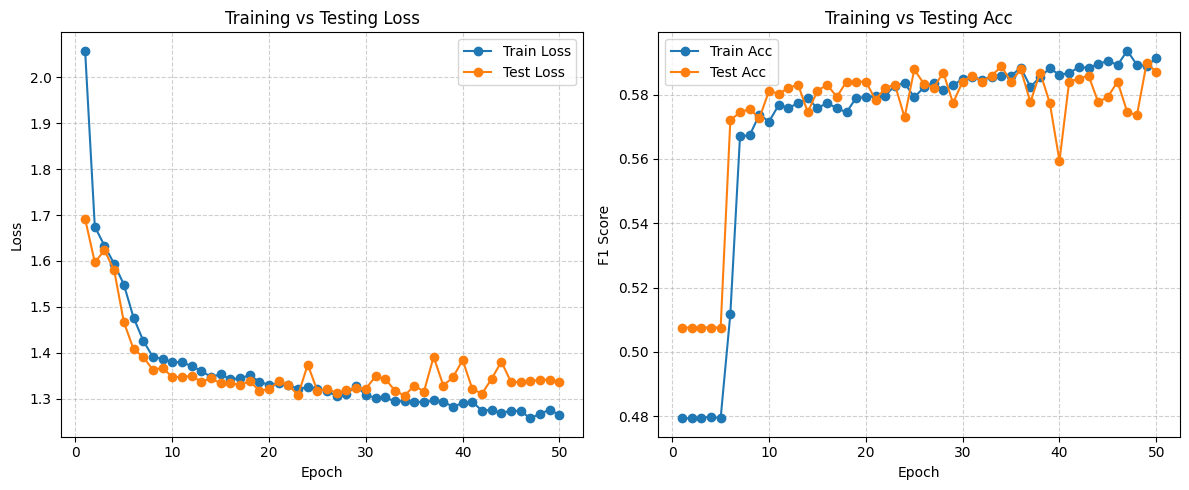

In [32]:
plot_training_results(model_0_results)

## Defining a Function to make prediction

In [33]:
import torch

def make_prediction(model, data_loader, device):
    all_preds = []
    all_labels = []

    model.to(device)
    model.eval()

    with torch.inference_mode():
        for cli_img, der_img, cli_meta_data, derm_meta_data, label in data_loader:
            cli_img = cli_img.to(device)
            der_img = der_img.to(device)
            cli_meta_data = cli_meta_data.to(device)
            derm_meta_data = derm_meta_data.to(device)
            label = label.to(device)

            # Forward pass
            y_pred = model(cli_img, der_img, cli_meta_data, derm_meta_data)

            # Convert model outputs to predicted class indices
            pred_classes = torch.argmax(y_pred, dim=1)

            # Convert one-hot labels to class indices if needed
            if label.ndim > 1 and label.size(1) > 1:
                true_classes = torch.argmax(label, dim=1)
            else:
                true_classes = label

            # Store predictions and labels
            all_preds.append(pred_classes.cpu())
            all_labels.append(true_classes.cpu())

    return torch.cat(all_preds, dim=0), torch.cat(all_labels, dim=0)


In [34]:
y_pred, y_test = make_prediction(model=model_0, data_loader = test_loader, device=device)

## Helps make a confusion Matrix based on the prediction made

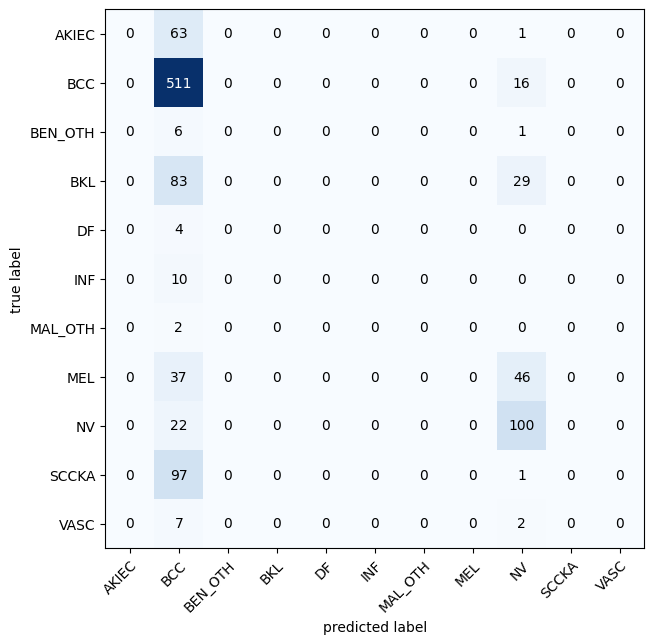

In [35]:
import mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


confmat = ConfusionMatrix(task="multiclass", num_classes=len(data.label_name))
confmat_tensor = confmat(preds=y_pred, target=y_test)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=data.label_name,
    figsize=(10,7)
)




## Helps Calculate the class weigths of all the label

In [36]:
import torch
from collections import Counter

all_labels = []

# Collect labels from the training loader
for batch in train_loader:
    _, _, _, _, label = batch

    # Move label to CPU and ensure long type
    label = label.long().cpu()

    # If one-hot, convert to class index
    if label.ndim > 1:
        label = torch.argmax(label, dim=1)

    all_labels.extend(label.tolist())

# Count frequency of each class
class_counts = Counter(all_labels)
num_classes = len(class_counts)
total_samples = sum(class_counts.values())

# Compute class weights
class_weights = [total_samples / class_counts[i] for i in range(num_classes)]
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class Counts:", class_counts)
print("Class Weights:", class_weights)



Class Counts: Counter({1: 1991, 8: 590, 3: 429, 9: 375, 7: 361, 0: 239, 4: 48, 5: 39, 2: 36, 10: 36, 6: 7})
Class Weights: tensor([ 17.3682,   2.0849, 115.3056,   9.6760,  86.4792, 106.4359, 593.0000,
         11.4986,   7.0356,  11.0693, 115.3056], device='cuda:0')


## Helps Calaculate Sample Weight for the Random Weighted Samplier

In [37]:
sample_weights = [class_weights[label] for label in all_labels]
sample_weights = torch.tensor(sample_weights, dtype=torch.float32)

In [38]:
sample_weights

tensor([2.0849, 7.0356, 9.6760,  ..., 2.0849, 2.0849, 9.6760])

## Builds the Weighted Random Sampler for the data loader

In [39]:
from torch.utils.data import WeightedRandomSampler


# Build sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # how many samples per epoch
    replacement=True                  # must be True for oversampling
)

weighted_train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=sampler,      # use sampler instead of shuffle=True
    num_workers=0
)



## Model with class-weighted loss function

In [48]:
NUM_EPOCHS = 50

model_1 = MultiModalLesionNet(
    input_size=3,
    hidden_unit=10,
    output_size=11,
    meta_data_dim=18,
    hidden_layer_DNN=10,
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001,
                             weight_decay=1e-4 # small L2 regularization
                             )




from timeit import default_timer as timer

start_time = timer()


model_1_results = train(model=model_1,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        )

end_time = timer()

print(f"Total Training Time: {end_time - start_time}")


  0%|          | 0/50 [00:00<?, ?it/s]


=== 🏋️ Training Metrics ===
Train Loss: 2.4352
Train Acc F1: 0.0146

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0836    0.1088    0.0945       239
         1.0     0.0000    0.0000    0.0000      1991
         2.0     0.0078    0.3333    0.0153        36
         3.0     0.0000    0.0000    0.0000       429
         4.0     0.0095    0.4583    0.0187        48
         5.0     0.0000    0.0000    0.0000        39
         6.0     0.0000    0.0000    0.0000         7
         7.0     0.0000    0.0000    0.0000       361
         8.0     0.0000    0.0000    0.0000       590
         9.0     0.0000    0.0000    0.0000       375
        10.0     0.0000    0.0000    0.0000        36

    accuracy                         0.0145      4151
   macro avg     0.0092    0.0819    0.0117      4151
weighted avg     0.0050    0.0145    0.0058      4151



  2%|▏         | 1/50 [00:55<45:10, 55.32s/it]


=== 🧪 Test Metrics ===
Test Loss: 2.4242
Test Acc: 0.0618

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0617    1.0000    0.1162        64
         1.0     0.0000    0.0000    0.0000       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.0000    0.0000    0.0000       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.0617      1038
   macro avg     0.0056    0.0909    0.0106      1038
weighted avg     0.0038    0.0617    0.0072      1038

Epoch: 1 | Train Loss: 2.4352| Train Acc: 0.0146  |  Test Loss: 2.4242| Test  Acc: 0.0618


  2%|▏         | 1/50 [01:22<1:07:40, 82.87s/it]


KeyboardInterrupt: 

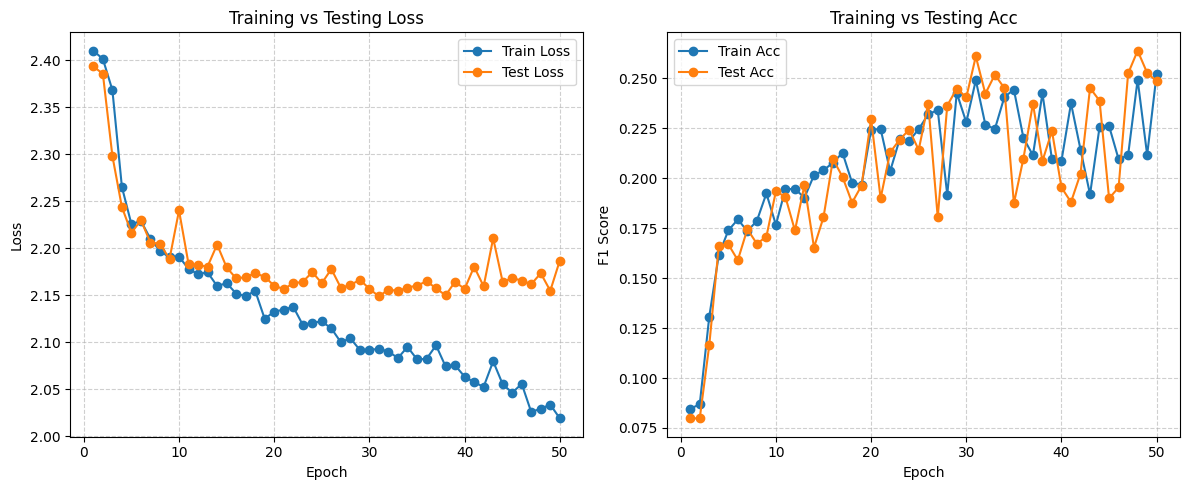

In [43]:
y_pred, y_test = make_prediction(model=model_1, data_loader = test_loader, device=device)
plot_training_results(model_1_results)

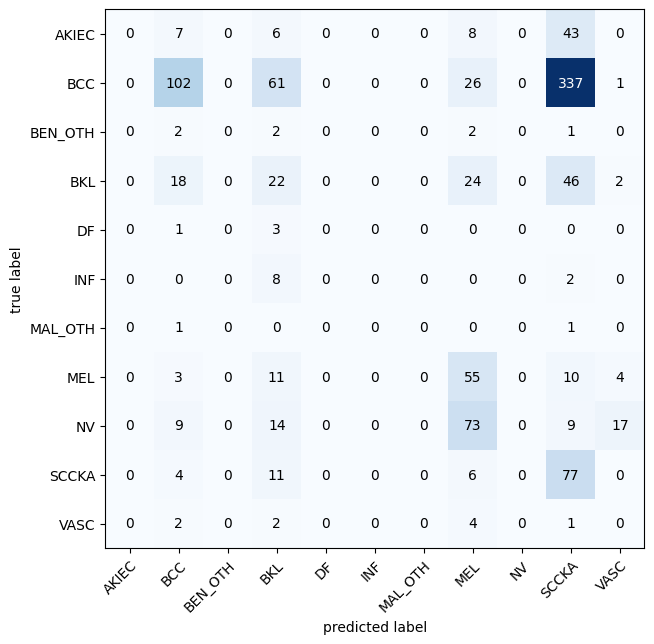

In [44]:
import mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


confmat = ConfusionMatrix(task="multiclass", num_classes=len(data.label_name))
confmat_tensor = confmat(preds=y_pred, target=y_test)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=data.label_name,
    figsize=(10,7)
)




## Model with Weighted Random Sampler

In [ ]:
NUM_EPOCHS = 50

model_2 = MultiModalLesionNet(
    input_size=3,
    hidden_unit=10,
    output_size=11,
    meta_data_dim=18,
    hidden_layer_DNN=10
).to(device)

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_2.parameters(),
                             lr=0.001,
                             )


from timeit import default_timer as timer

start_time = timer()


model_2_results = train(model=model_2,
                        train_dataloader=weighted_train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        )

end_time = timer()

print(f"Total Training Time: {end_time - start_time}")


  0%|          | 0/50 [00:00<?, ?it/s]


=== 🏋️ Training Metrics ===
Train Loss: 2.1164
Train Acc F1: 0.2926

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0687    0.4534    0.1193       247
         1.0     0.4708    0.5675    0.5146      1905
         2.0     0.0000    0.0000    0.0000        50
         3.0     0.0000    0.0000    0.0000       391
         4.0     0.0000    0.0000    0.0000        43
         5.0     0.0000    0.0000    0.0000        61
         6.0     0.0000    0.0000    0.0000        12
         7.0     0.0000    0.0000    0.0000       353
         8.0     0.0000    0.0000    0.0000       686
         9.0     0.0893    0.0538    0.0671       372
        10.0     0.0000    0.0000    0.0000        31

    accuracy                         0.2922      4151
   macro avg     0.0572    0.0977    0.0637      4151
weighted avg     0.2282    0.2922    0.2493      4151



  2%|▏         | 1/50 [00:53<43:30, 53.28s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.6819
Test Acc: 0.5076

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.5077    1.0000    0.6735       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.0000    0.0000    0.0000       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5077      1038
   macro avg     0.0462    0.0909    0.0612      1038
weighted avg     0.2578    0.5077    0.3419      1038

Epoch: 1 | Train Loss: 2.1164| Train Acc: 0.2926  |  Test Loss: 1.6819| Test  Acc: 0.5076

=== 🏋️ Training

  4%|▍         | 2/50 [01:46<42:31, 53.15s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.6024
Test Acc: 0.5076

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.5077    1.0000    0.6735       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.0000    0.0000    0.0000       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5077      1038
   macro avg     0.0462    0.0909    0.0612      1038
weighted avg     0.2578    0.5077    0.3419      1038

Epoch: 2 | Train Loss: 1.7108| Train Acc: 0.4632  |  Test Loss: 1.6024| Test  Acc: 0.5076

=== 🏋️ Training

  6%|▌         | 3/50 [02:39<41:37, 53.15s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.5823
Test Acc: 0.5076

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.5077    1.0000    0.6735       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.0000    0.0000    0.0000       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5077      1038
   macro avg     0.0462    0.0909    0.0612      1038
weighted avg     0.2578    0.5077    0.3419      1038

Epoch: 3 | Train Loss: 1.6362| Train Acc: 0.4792  |  Test Loss: 1.5823| Test  Acc: 0.5076

=== 🏋️ Training

  8%|▊         | 4/50 [03:33<40:51, 53.30s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.6666
Test Acc: 0.5076

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.5077    1.0000    0.6735       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.0000    0.0000    0.0000       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5077      1038
   macro avg     0.0462    0.0909    0.0612      1038
weighted avg     0.2578    0.5077    0.3419      1038

Epoch: 4 | Train Loss: 1.6360| Train Acc: 0.4739  |  Test Loss: 1.6666| Test  Acc: 0.5076

=== 🏋️ Training

 10%|█         | 5/50 [04:26<39:58, 53.31s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.5709
Test Acc: 0.5076

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.5077    1.0000    0.6735       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.0000    0.0000    0.0000       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5077      1038
   macro avg     0.0462    0.0909    0.0612      1038
weighted avg     0.2578    0.5077    0.3419      1038

Epoch: 5 | Train Loss: 1.6269| Train Acc: 0.4775  |  Test Loss: 1.5709| Test  Acc: 0.5076

=== 🏋️ Training

 12%|█▏        | 6/50 [05:16<38:16, 52.18s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.5643
Test Acc: 0.5076

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.5077    1.0000    0.6735       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.0000    0.0000    0.0000       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5077      1038
   macro avg     0.0462    0.0909    0.0612      1038
weighted avg     0.2578    0.5077    0.3419      1038

Epoch: 6 | Train Loss: 1.6582| Train Acc: 0.4619  |  Test Loss: 1.5643| Test  Acc: 0.5076

=== 🏋️ Training

 14%|█▍        | 7/50 [06:07<37:07, 51.81s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.5511
Test Acc: 0.5076

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.5077    1.0000    0.6735       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.0000    0.0000    0.0000       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5077      1038
   macro avg     0.0462    0.0909    0.0612      1038
weighted avg     0.2578    0.5077    0.3419      1038

Epoch: 7 | Train Loss: 1.5993| Train Acc: 0.4792  |  Test Loss: 1.5511| Test  Acc: 0.5076

=== 🏋️ Training

 16%|█▌        | 8/50 [06:57<35:47, 51.14s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.4764
Test Acc: 0.5114

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.5182    0.9981    0.6822       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.2174    0.0602    0.0943        83
         8.0     0.0000    0.0000    0.0000       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5116      1038
   macro avg     0.0669    0.0962    0.0706      1038
weighted avg     0.2805    0.5116    0.3539      1038

Epoch: 8 | Train Loss: 1.5899| Train Acc: 0.4633  |  Test Loss: 1.4764| Test  Acc: 0.5114

=== 🏋️ Training

 18%|█▊        | 9/50 [07:46<34:39, 50.72s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.4692
Test Acc: 0.5114

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.5274    0.9848    0.6870       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.2222    0.1446    0.1752        83
         8.0     0.0000    0.0000    0.0000       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5116      1038
   macro avg     0.0682    0.1027    0.0784      1038
weighted avg     0.2856    0.5116    0.3628      1038

Epoch: 9 | Train Loss: 1.4648| Train Acc: 0.4971  |  Test Loss: 1.4692| Test  Acc: 0.5114

=== 🏋️ Training

 20%|██        | 10/50 [08:35<33:21, 50.05s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.4194
Test Acc: 0.5423

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6268    0.9241    0.7469       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.2454    0.4819    0.3252        83
         8.0     0.3878    0.3115    0.3455       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5443      1038
   macro avg     0.1145    0.1561    0.1289      1038
weighted avg     0.3834    0.5443    0.4458      1038

Epoch: 10 | Train Loss: 1.4320| Train Acc: 0.4958  |  Test Loss: 1.4194| Test  Acc: 0.5423

=== 🏋️ Trainin

 22%|██▏       | 11/50 [09:25<32:37, 50.19s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.4428
Test Acc: 0.5395

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6657    0.8539    0.7481       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.3094    0.9180    0.4628       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5414      1038
   macro avg     0.0886    0.1611    0.1101      1038
weighted avg     0.3743    0.5414    0.4342      1038

Epoch: 11 | Train Loss: 1.3194| Train Acc: 0.5703  |  Test Loss: 1.4428| Test  Acc: 0.5395

=== 🏋️ Trainin

 24%|██▍       | 12/50 [10:15<31:44, 50.13s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3349
Test Acc: 0.5777

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6338    0.9393    0.7569       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4125    0.8689    0.5594       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5790      1038
   macro avg     0.0951    0.1644    0.1197      1038
weighted avg     0.3703    0.5790    0.4500      1038

Epoch: 12 | Train Loss: 1.2842| Train Acc: 0.5915  |  Test Loss: 1.3349| Test  Acc: 0.5777

=== 🏋️ Trainin

 26%|██▌       | 13/50 [11:05<30:48, 49.97s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3933
Test Acc: 0.5530

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6503    0.8824    0.7488       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.3406    0.9016    0.4944       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5539      1038
   macro avg     0.0901    0.1622    0.1130      1038
weighted avg     0.3702    0.5539    0.4383      1038

Epoch: 13 | Train Loss: 1.2492| Train Acc: 0.6006  |  Test Loss: 1.3933| Test  Acc: 0.5530

=== 🏋️ Trainin

 28%|██▊       | 14/50 [11:59<30:44, 51.24s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3074
Test Acc: 0.5874

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6204    0.9583    0.7532       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4688    0.8607    0.6069       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5877      1038
   macro avg     0.0990    0.1654    0.1236      1038
weighted avg     0.3701    0.5877    0.4537      1038

Epoch: 14 | Train Loss: 1.2598| Train Acc: 0.5937  |  Test Loss: 1.3074| Test  Acc: 0.5874

=== 🏋️ Trainin

 30%|███       | 15/50 [12:53<30:24, 52.11s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3167
Test Acc: 0.5827

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6267    0.9431    0.7530       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4408    0.8852    0.5886       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5829      1038
   macro avg     0.0971    0.1662    0.1220      1038
weighted avg     0.3700    0.5829    0.4515      1038

Epoch: 15 | Train Loss: 1.2380| Train Acc: 0.5986  |  Test Loss: 1.3167| Test  Acc: 0.5827

=== 🏋️ Trainin

 32%|███▏      | 16/50 [13:47<29:51, 52.69s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3187
Test Acc: 0.5855

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6244    0.9526    0.7543       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4530    0.8689    0.5955       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5857      1038
   macro avg     0.0979    0.1656    0.1227      1038
weighted avg     0.3702    0.5857    0.4530      1038

Epoch: 16 | Train Loss: 1.2106| Train Acc: 0.6016  |  Test Loss: 1.3187| Test  Acc: 0.5855

=== 🏋️ Trainin

 34%|███▍      | 17/50 [14:41<29:08, 52.97s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3144
Test Acc: 0.5874

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6179    0.9545    0.7502       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4777    0.8770    0.6185       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5877      1038
   macro avg     0.0996    0.1665    0.1244      1038
weighted avg     0.3699    0.5877    0.4536      1038

Epoch: 17 | Train Loss: 1.2175| Train Acc: 0.6004  |  Test Loss: 1.3144| Test  Acc: 0.5874

=== 🏋️ Trainin

 36%|███▌      | 18/50 [15:32<27:51, 52.24s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3233
Test Acc: 0.5817

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6275    0.9431    0.7536       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4350    0.8770    0.5815       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5819      1038
   macro avg     0.0966    0.1655    0.1214      1038
weighted avg     0.3697    0.5819    0.4510      1038

Epoch: 18 | Train Loss: 1.1943| Train Acc: 0.6027  |  Test Loss: 1.3233| Test  Acc: 0.5817

=== 🏋️ Trainin

 38%|███▊      | 19/50 [16:22<26:39, 51.59s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3001
Test Acc: 0.5912

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6192    0.9658    0.7546       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4861    0.8607    0.6213       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5915      1038
   macro avg     0.1005    0.1660    0.1251      1038
weighted avg     0.3715    0.5915    0.4562      1038

Epoch: 19 | Train Loss: 1.1602| Train Acc: 0.6217  |  Test Loss: 1.3001| Test  Acc: 0.5912

=== 🏋️ Trainin

 40%|████      | 20/50 [17:12<25:41, 51.38s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3381
Test Acc: 0.5902

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6233    0.9639    0.7571       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4709    0.8607    0.6087       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5906      1038
   macro avg     0.0995    0.1659    0.1242      1038
weighted avg     0.3718    0.5906    0.4559      1038

Epoch: 20 | Train Loss: 1.1428| Train Acc: 0.6246  |  Test Loss: 1.3381| Test  Acc: 0.5902

=== 🏋️ Trainin

 42%|████▏     | 21/50 [18:04<24:47, 51.29s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3337
Test Acc: 0.5846

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6301    0.9469    0.7566       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.0000    0.0000    0.0000        83
         8.0     0.4390    0.8852    0.5870       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5848      1038
   macro avg     0.0972    0.1666    0.1221      1038
weighted avg     0.3715    0.5848    0.4531      1038

Epoch: 21 | Train Loss: 1.1652| Train Acc: 0.6175  |  Test Loss: 1.3337| Test  Acc: 0.5846

=== 🏋️ Trainin

 44%|████▍     | 22/50 [18:55<23:53, 51.19s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3016
Test Acc: 0.5912

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6238    0.9564    0.7551       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.1765    0.0361    0.0600        83
         8.0     0.5023    0.8770    0.6388       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5915      1038
   macro avg     0.1184    0.1700    0.1322      1038
weighted avg     0.3898    0.5915    0.4632      1038

Epoch: 22 | Train Loss: 1.1551| Train Acc: 0.6076  |  Test Loss: 1.3016| Test  Acc: 0.5912

=== 🏋️ Trainin

 46%|████▌     | 23/50 [19:44<22:50, 50.76s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3094
Test Acc: 0.5950

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6201    0.9602    0.7535       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.2222    0.0723    0.1091        83
         8.0     0.5436    0.8689    0.6688       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5954      1038
   macro avg     0.1260    0.1728    0.1392      1038
weighted avg     0.3965    0.5954    0.4699      1038

Epoch: 23 | Train Loss: 1.1489| Train Acc: 0.6195  |  Test Loss: 1.3094| Test  Acc: 0.5950

=== 🏋️ Trainin

 48%|████▊     | 24/50 [20:35<21:55, 50.59s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3383
Test Acc: 0.5969

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6087    0.9829    0.7518       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.2308    0.0361    0.0625        83
         8.0     0.5690    0.8115    0.6689       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5973      1038
   macro avg     0.1280    0.1664    0.1348      1038
weighted avg     0.3944    0.5973    0.4653      1038

Epoch: 24 | Train Loss: 1.1359| Train Acc: 0.6104  |  Test Loss: 1.3383| Test  Acc: 0.5969

=== 🏋️ Trainin

 50%|█████     | 25/50 [21:24<20:59, 50.38s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3210
Test Acc: 0.5836

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6181    0.9583    0.7515       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.1556    0.0843    0.1094        83
         8.0     0.5341    0.7705    0.6309       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5838      1038
   macro avg     0.1189    0.1648    0.1356      1038
weighted avg     0.3890    0.5838    0.4644      1038

Epoch: 25 | Train Loss: 1.1283| Train Acc: 0.6119  |  Test Loss: 1.3210| Test  Acc: 0.5836

=== 🏋️ Trainin

 52%|█████▏    | 26/50 [22:15<20:09, 50.39s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3698
Test Acc: 0.5912

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6173    0.9639    0.7526       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.1304    0.0361    0.0566        83
         8.0     0.5450    0.8443    0.6624       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5915      1038
   macro avg     0.1175    0.1677    0.1338      1038
weighted avg     0.3879    0.5915    0.4645      1038

Epoch: 26 | Train Loss: 1.1138| Train Acc: 0.6190  |  Test Loss: 1.3698| Test  Acc: 0.5912

=== 🏋️ Trainin

 54%|█████▍    | 27/50 [23:04<19:14, 50.18s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3465
Test Acc: 0.5959

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6311    0.9545    0.7598       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.3333    0.0179    0.0339       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.3030    0.1205    0.1724        83
         8.0     0.5149    0.8525    0.6420       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5963      1038
   macro avg     0.1620    0.1768    0.1462      1038
weighted avg     0.4411    0.5963    0.4787      1038

Epoch: 27 | Train Loss: 1.1178| Train Acc: 0.6168  |  Test Loss: 1.3465| Test  Acc: 0.5959

=== 🏋️ Trainin

 56%|█████▌    | 28/50 [23:53<18:16, 49.82s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3641
Test Acc: 0.5931

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6242    0.9583    0.7560       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.2857    0.0964    0.1441        83
         8.0     0.5365    0.8443    0.6561       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5934      1038
   macro avg     0.1315    0.1726    0.1415      1038
weighted avg     0.4028    0.5934    0.4725      1038

Epoch: 28 | Train Loss: 1.0529| Train Acc: 0.6375  |  Test Loss: 1.3641| Test  Acc: 0.5931

=== 🏋️ Trainin

 58%|█████▊    | 29/50 [24:42<17:19, 49.49s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3788
Test Acc: 0.5931

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6230    0.9658    0.7574       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.2000    0.0179    0.0328       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.1515    0.0602    0.0862        83
         8.0     0.5618    0.8197    0.6667       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5934      1038
   macro avg     0.1397    0.1694    0.1403      1038
weighted avg     0.4160    0.5934    0.4733      1038

Epoch: 29 | Train Loss: 1.0961| Train Acc: 0.6203  |  Test Loss: 1.3788| Test  Acc: 0.5931

=== 🏋️ Trainin

 60%|██████    | 30/50 [25:31<16:24, 49.25s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3671
Test Acc: 0.5836

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6291    0.9431    0.7547       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0714    0.0089    0.0159       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.2115    0.1325    0.1630        83
         8.0     0.5330    0.7951    0.6382       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5838      1038
   macro avg     0.1314    0.1709    0.1429      1038
weighted avg     0.4067    0.5838    0.4729      1038

Epoch: 30 | Train Loss: 1.1050| Train Acc: 0.6213  |  Test Loss: 1.3671| Test  Acc: 0.5836

=== 🏋️ Trainin

 62%|██████▏   | 31/50 [26:19<15:31, 49.02s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3495
Test Acc: 0.5836

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6296    0.9450    0.7557       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.2222    0.0179    0.0331       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.1972    0.1687    0.1818        83
         8.0     0.5509    0.7541    0.6367       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5838      1038
   macro avg     0.1454    0.1714    0.1461      1038
weighted avg     0.4241    0.5838    0.4766      1038

Epoch: 31 | Train Loss: 1.0813| Train Acc: 0.6265  |  Test Loss: 1.3495| Test  Acc: 0.5836

=== 🏋️ Trainin

 64%|██████▍   | 32/50 [27:08<14:42, 49.04s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3792
Test Acc: 0.5789

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6296    0.9355    0.7527       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0000    0.0000    0.0000       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.1807    0.1807    0.1807        83
         8.0     0.5671    0.7623    0.6503       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5790      1038
   macro avg     0.1252    0.1708    0.1440      1038
weighted avg     0.4008    0.5790    0.4730      1038

Epoch: 32 | Train Loss: 1.0714| Train Acc: 0.6333  |  Test Loss: 1.3792| Test  Acc: 0.5789

=== 🏋️ Trainin

 66%|██████▌   | 33/50 [27:57<13:50, 48.86s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3675
Test Acc: 0.5798

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6283    0.9431    0.7542       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0769    0.0089    0.0160       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.1928    0.1928    0.1928        83
         8.0     0.5828    0.7213    0.6447       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5800      1038
   macro avg     0.1346    0.1696    0.1461      1038
weighted avg     0.4112    0.5800    0.4758      1038

Epoch: 33 | Train Loss: 1.0660| Train Acc: 0.6330  |  Test Loss: 1.3675| Test  Acc: 0.5798

=== 🏋️ Trainin

 68%|██████▊   | 34/50 [28:46<13:01, 48.83s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3648
Test Acc: 0.5808

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6290    0.9393    0.7534       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.1111    0.0089    0.0165       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.1977    0.2048    0.2012        83
         8.0     0.5769    0.7377    0.6475       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5809      1038
   macro avg     0.1377    0.1719    0.1471      1038
weighted avg     0.4149    0.5809    0.4765      1038

Epoch: 34 | Train Loss: 1.0649| Train Acc: 0.6334  |  Test Loss: 1.3648| Test  Acc: 0.5808

=== 🏋️ Trainin

 70%|███████   | 35/50 [29:34<12:11, 48.76s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.4346
Test Acc: 0.5893

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6147    0.9658    0.7513       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.5000    0.0268    0.0508       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.1786    0.1205    0.1439        83
         8.0     0.6081    0.7377    0.6667       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5896      1038
   macro avg     0.1729    0.1683    0.1466      1038
weighted avg     0.4518    0.5896    0.4768      1038

Epoch: 35 | Train Loss: 1.0702| Train Acc: 0.6341  |  Test Loss: 1.4346| Test  Acc: 0.5893

=== 🏋️ Trainin

 72%|███████▏  | 36/50 [30:23<11:20, 48.64s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.4220
Test Acc: 0.5722

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6358    0.9108    0.7488       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.2222    0.0714    0.1081       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.2037    0.2651    0.2304        83
         8.0     0.6043    0.6885    0.6437       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5723      1038
   macro avg     0.1515    0.1760    0.1574      1038
weighted avg     0.4341    0.5723    0.4859      1038

Epoch: 36 | Train Loss: 1.0362| Train Acc: 0.6443  |  Test Loss: 1.4220| Test  Acc: 0.5722

=== 🏋️ Trainin

 74%|███████▍  | 37/50 [31:11<10:30, 48.53s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.5019
Test Acc: 0.5779

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6359    0.9279    0.7546       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.2308    0.0536    0.0870       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.1733    0.1566    0.1646        83
         8.0     0.5476    0.7541    0.6345       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5780      1038
   macro avg     0.1443    0.1720    0.1491      1038
weighted avg     0.4260    0.5780    0.4802      1038

Epoch: 37 | Train Loss: 1.0577| Train Acc: 0.6445  |  Test Loss: 1.5019| Test  Acc: 0.5779

=== 🏋️ Trainin

 76%|███████▌  | 38/50 [32:00<09:44, 48.71s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3631
Test Acc: 0.5789

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6221    0.9526    0.7526       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0909    0.0179    0.0299       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.2234    0.2530    0.2373        83
         8.0     0.6609    0.6230    0.6414       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5790      1038
   macro avg     0.1452    0.1679    0.1510      1038
weighted avg     0.4212    0.5790    0.4797      1038

Epoch: 38 | Train Loss: 1.0601| Train Acc: 0.6298  |  Test Loss: 1.3631| Test  Acc: 0.5789

=== 🏋️ Trainin

 78%|███████▊  | 39/50 [32:49<08:57, 48.85s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.3921
Test Acc: 0.5791

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6269    0.9469    0.7543       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.0714    0.0089    0.0159       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.2059    0.2530    0.2270        83
         8.0     0.6270    0.6475    0.6371       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5780      1038
   macro avg     0.1392    0.1688    0.1486      1038
weighted avg     0.4161    0.5780    0.4777      1038

Epoch: 39 | Train Loss: 0.9797| Train Acc: 0.6627  |  Test Loss: 1.3921| Test  Acc: 0.5791

=== 🏋️ Trainin

 80%|████████  | 40/50 [33:39<08:11, 49.12s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.4604
Test Acc: 0.5808

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6296    0.9450    0.7557       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.1579    0.0268    0.0458       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.2024    0.2048    0.2036        83
         8.0     0.5903    0.6967    0.6391       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5809      1038
   macro avg     0.1436    0.1703    0.1495      1038
weighted avg     0.4222    0.5809    0.4800      1038

Epoch: 40 | Train Loss: 1.0011| Train Acc: 0.6481  |  Test Loss: 1.4604| Test  Acc: 0.5808

=== 🏋️ Trainin

 82%|████████▏ | 41/50 [34:28<07:22, 49.21s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.5812
Test Acc: 0.5874

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6262    0.9602    0.7581       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.2059    0.0625    0.0959       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.2647    0.2169    0.2384        83
         8.0     0.6172    0.6475    0.6320       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5877      1038
   macro avg     0.1558    0.1716    0.1568      1038
weighted avg     0.4339    0.5877    0.4886      1038

Epoch: 41 | Train Loss: 1.0137| Train Acc: 0.6471  |  Test Loss: 1.5812| Test  Acc: 0.5874

=== 🏋️ Trainin

 84%|████████▍ | 42/50 [35:20<06:39, 49.95s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.4617
Test Acc: 0.5777

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6471    0.9013    0.7534       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.1930    0.0982    0.1302       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.2530    0.2530    0.2530        83
         8.0     0.5732    0.7705    0.6573       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5790      1038
   macro avg     0.1515    0.1839    0.1631      1038
weighted avg     0.4370    0.5790    0.4940      1038

Epoch: 42 | Train Loss: 0.9627| Train Acc: 0.6675  |  Test Loss: 1.4617| Test  Acc: 0.5777

=== 🏋️ Trainin

 86%|████████▌ | 43/50 [36:11<05:52, 50.30s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.4754
Test Acc: 0.5810

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6269    0.9469    0.7543       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.1316    0.0446    0.0667       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.2584    0.2771    0.2674        83
         8.0     0.6522    0.6148    0.6329       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5800      1038
   macro avg     0.1517    0.1712    0.1565      1038
weighted avg     0.4298    0.5800    0.4860      1038

Epoch: 43 | Train Loss: 0.9639| Train Acc: 0.6629  |  Test Loss: 1.4754| Test  Acc: 0.5810

=== 🏋️ Trainin

 88%|████████▊ | 44/50 [37:00<04:59, 49.99s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.4742
Test Acc: 0.5758

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6253    0.9469    0.7532       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.1613    0.0446    0.0699       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.2316    0.2651    0.2472        83
         8.0     0.6404    0.5984    0.6186       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5771      1038
   macro avg     0.1508    0.1686    0.1535      1038
weighted avg     0.4287    0.5771    0.4824      1038

Epoch: 44 | Train Loss: 0.9998| Train Acc: 0.6539  |  Test Loss: 1.4742| Test  Acc: 0.5758

=== 🏋️ Trainin

 90%|█████████ | 45/50 [37:51<04:10, 50.03s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.4265
Test Acc: 0.5855

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6302    0.9412    0.7549       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.2000    0.0714    0.1053       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.2778    0.3012    0.2890        83
         8.0     0.6529    0.6475    0.6502       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5857      1038
   macro avg     0.1601    0.1783    0.1636      1038
weighted avg     0.4405    0.5857    0.4942      1038

Epoch: 45 | Train Loss: 0.9368| Train Acc: 0.6779  |  Test Loss: 1.4265| Test  Acc: 0.5855

=== 🏋️ Trainin

 92%|█████████▏| 46/50 [38:43<03:22, 50.67s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.4480
Test Acc: 0.5760

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6536    0.9165    0.7630       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.1864    0.0982    0.1287       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.2193    0.3012    0.2538        83
         8.0     0.6270    0.6475    0.6371       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5761      1038
   macro avg     0.1533    0.1785    0.1621      1038
weighted avg     0.4432    0.5761    0.4965      1038

Epoch: 46 | Train Loss: 0.9305| Train Acc: 0.6745  |  Test Loss: 1.4480| Test  Acc: 0.5760

=== 🏋️ Trainin

 94%|█████████▍| 47/50 [39:35<02:33, 51.29s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.5878
Test Acc: 0.5808

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6318    0.9412    0.7561       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.1111    0.0446    0.0637       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.2254    0.1928    0.2078        83
         8.0     0.6277    0.7049    0.6641       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5809      1038
   macro avg     0.1451    0.1712    0.1538      1038
weighted avg     0.4246    0.5809    0.4854      1038

Epoch: 47 | Train Loss: 0.9582| Train Acc: 0.6739  |  Test Loss: 1.5878| Test  Acc: 0.5808

=== 🏋️ Trainin

 96%|█████████▌| 48/50 [40:32<01:45, 52.77s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.4794
Test Acc: 0.5597

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6517    0.8805    0.7490       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.1646    0.1161    0.1361       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.2126    0.3253    0.2571        83
         8.0     0.6500    0.6393    0.6446       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5607      1038
   macro avg     0.1526    0.1783    0.1624      1038
weighted avg     0.4420    0.5607    0.4913      1038

Epoch: 48 | Train Loss: 0.9716| Train Acc: 0.6475  |  Test Loss: 1.4794| Test  Acc: 0.5597

=== 🏋️ Trainin

 98%|█████████▊| 49/50 [41:26<00:53, 53.30s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.5251
Test Acc: 0.5817

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6378    0.9355    0.7585       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.1552    0.0804    0.1059       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.2558    0.2651    0.2604        83
         8.0     0.6612    0.6557    0.6584       122
         9.0     0.0000    0.0000    0.0000        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5819      1038
   macro avg     0.1554    0.1761    0.1621      1038
weighted avg     0.4387    0.5819    0.4947      1038

Epoch: 49 | Train Loss: 0.9516| Train Acc: 0.6585  |  Test Loss: 1.5251| Test  Acc: 0.5817

=== 🏋️ Trainin

100%|██████████| 50/50 [42:21<00:00, 50.83s/it]


=== 🧪 Test Metrics ===
Test Loss: 1.5256
Test Acc: 0.5839

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        64
         1.0     0.6272    0.9450    0.7540       527
         2.0     0.0000    0.0000    0.0000         7
         3.0     0.1818    0.0536    0.0828       112
         4.0     0.0000    0.0000    0.0000         4
         5.0     0.0000    0.0000    0.0000        10
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.2708    0.3133    0.2905        83
         8.0     0.6981    0.6066    0.6491       122
         9.0     0.1111    0.0102    0.0187        98
        10.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5829      1038
   macro avg     0.1717    0.1753    0.1632      1038
weighted avg     0.4523    0.5829    0.4930      1038

Epoch: 50 | Train Loss: 0.9197| Train Acc: 0.6740  |  Test Loss: 1.5256| Test  Acc: 0.5839
Total Training 

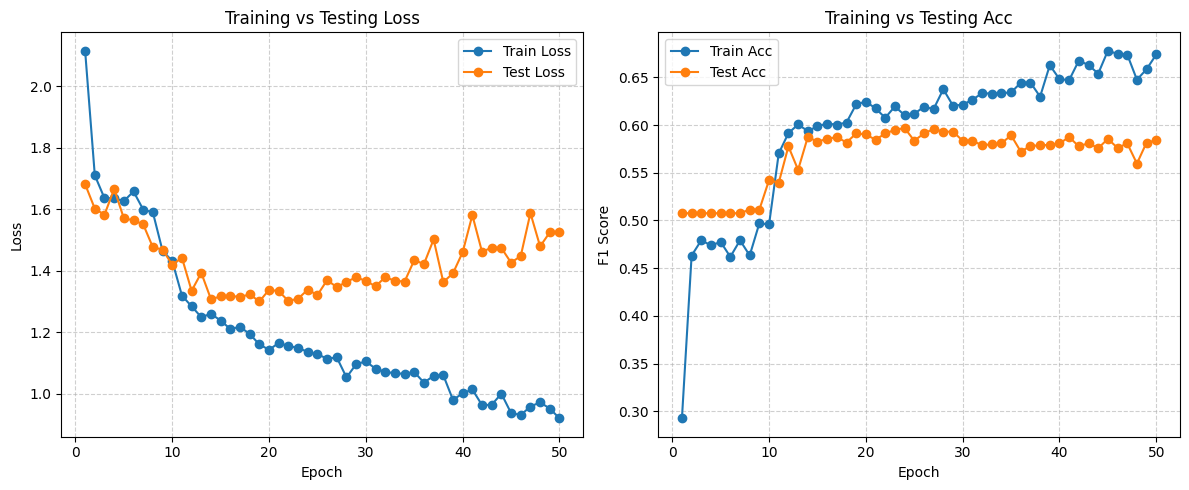

In [46]:
y_pred, y_test = make_prediction(model=model_2, data_loader =  test_loader, device=device)
plot_training_results(model_2_results)

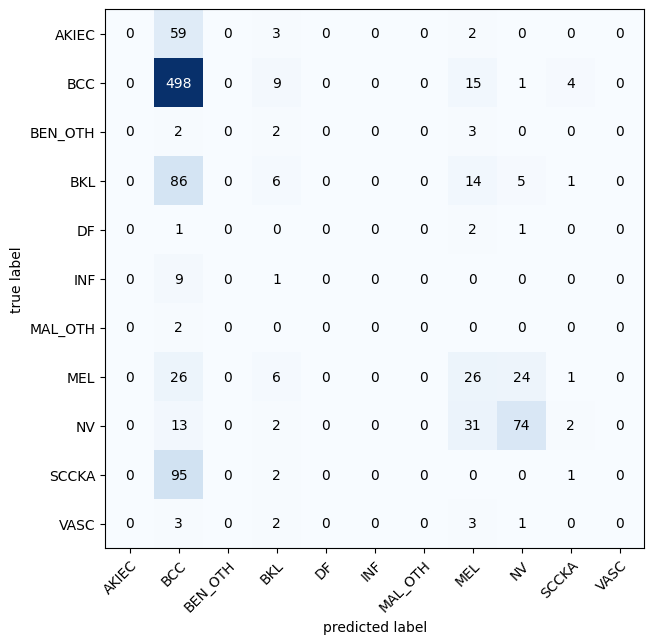

In [47]:
import mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


confmat = ConfusionMatrix(task="multiclass", num_classes=len(data.label_name))
confmat_tensor = confmat(preds=y_pred, target=y_test)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=data.label_name,
    figsize=(10,7)
)




## Creating a standalone final model

Creating a data loader for the final model with full training dataset. Here we are not splitting the data

In [49]:
data_loader = DataLoader(
    data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

## Calculates the new class weights based on all the data

In [59]:
import torch
from collections import Counter

all_labels = []

# Collect labels from the training loader
for batch in data_loader:
    _, _, _, _, label = batch

    # Move label to CPU and ensure long type
    label = label.long().cpu()

    # If one-hot, convert to class index
    if label.ndim > 1:
        label = torch.argmax(label, dim=1)

    all_labels.extend(label.tolist())

# Count frequency of each class
class_counts = Counter(all_labels)
num_classes = len(class_counts)
total_samples = sum(class_counts.values())

# Compute class weights
class_weights = [total_samples / class_counts[i] for i in range(num_classes)]
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: Counter({1: 2518, 8: 712, 3: 541, 9: 473, 7: 444, 0: 303, 4: 52, 5: 49, 10: 45, 2: 43, 6: 9})
Class Weights: tensor([ 17.1254,   2.0608, 120.6744,   9.5915,  99.7885, 105.8980, 576.5555,
         11.6869,   7.2879,  10.9704, 115.3111], device='cuda:0')


## Calculating the new sample weights for the new data sampler with all the data present

In [60]:
sample_weights = [class_weights[label] for label in all_labels]
sample_weights = torch.tensor(sample_weights, dtype=torch.float32)

In [ ]:
sample_weights

In [61]:
# Build sampler
full_data_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # how many samples per epoch
    replacement=True                  # must be True for oversampling
)

weighted_data_loader = DataLoader(
    data,
    batch_size=32,
    sampler=full_data_sampler,      # use sampler instead of shuffle=True
    num_workers=0
)

In [62]:
NUM_EPOCHS = 50

# using the model_2 code from the above to create the final model

final_model = MultiModalLesionNet(
    input_size=3,
    hidden_unit=10,
    output_size=11,
    meta_data_dim=18,
    hidden_layer_DNN=10
).to(device)

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=final_model.parameters(),
                             lr=0.001,
                             )


from timeit import default_timer as timer

start_time = timer()


final_model_2_results = train(model=final_model,
                        train_dataloader=weighted_data_loader,
                        test_dataloader=None,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        )

end_time = timer()

print(f"Total Training Time: {end_time - start_time}")


  2%|▏         | 1/50 [00:51<41:46, 51.16s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.9648
Train Acc F1: 0.3346

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       334
         1.0     0.5222    0.5811    0.5501      2736
         2.0     0.0000    0.0000    0.0000        53
         3.0     0.0000    0.0000    0.0000       552
         4.0     0.0000    0.0000    0.0000        44
         5.0     0.0000    0.0000    0.0000        52
         6.0     0.0000    0.0000    0.0000        11
         7.0     0.0649    0.3725    0.1105       357
         8.0     0.0000    0.0000    0.0000       583
         9.0     0.0732    0.0141    0.0237       425
        10.0     0.0000    0.0000    0.0000        42

    accuracy                         0.3332      5189
   macro avg     0.0600    0.0880    0.0622      5189
weighted avg     0.2858    0.3332    0.2996      5189

Epoch: 1 | Train Loss: 1.9648| Train Acc: 0.3346


  4%|▍         | 2/50 [01:42<40:49, 51.04s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.5902
Train Acc F1: 0.5219

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       336
         1.0     0.5236    1.0000    0.6873      2717
         2.0     0.0000    0.0000    0.0000        75
         3.0     0.0000    0.0000    0.0000       560
         4.0     0.0000    0.0000    0.0000        37
         5.0     0.0000    0.0000    0.0000        60
         6.0     0.0000    0.0000    0.0000        15
         7.0     0.0000    0.0000    0.0000       378
         8.0     0.0000    0.0000    0.0000       590
         9.0     0.0000    0.0000    0.0000       395
        10.0     0.0000    0.0000    0.0000        26

    accuracy                         0.5236      5189
   macro avg     0.0476    0.0909    0.0625      5189
weighted avg     0.2742    0.5236    0.3599      5189

Epoch: 2 | Train Loss: 1.5902| Train Acc: 0.5219


  6%|▌         | 3/50 [02:33<40:05, 51.18s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.5566
Train Acc F1: 0.5327

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       320
         1.0     0.5313    1.0000    0.6939      2757
         2.0     0.0000    0.0000    0.0000        50
         3.0     0.0000    0.0000    0.0000       581
         4.0     0.0000    0.0000    0.0000        42
         5.0     0.0000    0.0000    0.0000        50
         6.0     0.0000    0.0000    0.0000        22
         7.0     0.0000    0.0000    0.0000       357
         8.0     0.0000    0.0000    0.0000       571
         9.0     0.0000    0.0000    0.0000       406
        10.0     0.0000    0.0000    0.0000        33

    accuracy                         0.5313      5189
   macro avg     0.0483    0.0909    0.0631      5189
weighted avg     0.2823    0.5313    0.3687      5189

Epoch: 3 | Train Loss: 1.5566| Train Acc: 0.5327


  8%|▊         | 4/50 [03:24<39:13, 51.16s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.5601
Train Acc F1: 0.5242

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       327
         1.0     0.5238    1.0000    0.6875      2718
         2.0     0.0000    0.0000    0.0000        57
         3.0     0.0000    0.0000    0.0000       526
         4.0     0.0000    0.0000    0.0000        38
         5.0     0.0000    0.0000    0.0000        55
         6.0     0.0000    0.0000    0.0000        16
         7.0     0.0000    0.0000    0.0000       383
         8.0     0.0000    0.0000    0.0000       642
         9.0     0.0000    0.0000    0.0000       399
        10.0     0.0000    0.0000    0.0000        28

    accuracy                         0.5238      5189
   macro avg     0.0476    0.0909    0.0625      5189
weighted avg     0.2744    0.5238    0.3601      5189

Epoch: 4 | Train Loss: 1.5601| Train Acc: 0.5242


 10%|█         | 5/50 [04:15<38:25, 51.23s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.5332
Train Acc F1: 0.5305

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       324
         1.0     0.5302    1.0000    0.6929      2751
         2.0     0.0000    0.0000    0.0000        63
         3.0     0.0000    0.0000    0.0000       533
         4.0     0.0000    0.0000    0.0000        40
         5.0     0.0000    0.0000    0.0000        44
         6.0     0.0000    0.0000    0.0000        22
         7.0     0.0000    0.0000    0.0000       371
         8.0     0.0000    0.0000    0.0000       639
         9.0     0.0000    0.0000    0.0000       379
        10.0     0.0000    0.0000    0.0000        23

    accuracy                         0.5302      5189
   macro avg     0.0482    0.0909    0.0630      5189
weighted avg     0.2811    0.5302    0.3674      5189

Epoch: 5 | Train Loss: 1.5332| Train Acc: 0.5305


 12%|█▏        | 6/50 [05:07<37:42, 51.41s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.5332
Train Acc F1: 0.5305

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       319
         1.0     0.5302    1.0000    0.6929      2751
         2.0     0.0000    0.0000    0.0000        70
         3.0     0.0000    0.0000    0.0000       556
         4.0     0.0000    0.0000    0.0000        37
         5.0     0.0000    0.0000    0.0000        49
         6.0     0.0000    0.0000    0.0000        16
         7.0     0.0000    0.0000    0.0000       386
         8.0     0.0000    0.0000    0.0000       578
         9.0     0.0000    0.0000    0.0000       388
        10.0     0.0000    0.0000    0.0000        39

    accuracy                         0.5302      5189
   macro avg     0.0482    0.0909    0.0630      5189
weighted avg     0.2811    0.5302    0.3674      5189

Epoch: 6 | Train Loss: 1.5332| Train Acc: 0.5305


 14%|█▍        | 7/50 [05:59<36:52, 51.46s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.5232
Train Acc F1: 0.5220

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       328
         1.0     0.5226    1.0000    0.6865      2712
         2.0     0.0000    0.0000    0.0000        45
         3.0     0.0000    0.0000    0.0000       578
         4.0     0.0000    0.0000    0.0000        35
         5.0     0.0000    0.0000    0.0000        55
         6.0     0.0000    0.0000    0.0000        17
         7.0     0.0000    0.0000    0.0000       385
         8.0     0.0000    0.0000    0.0000       622
         9.0     0.0000    0.0000    0.0000       378
        10.0     0.0000    0.0000    0.0000        34

    accuracy                         0.5226      5189
   macro avg     0.0475    0.0909    0.0624      5189
weighted avg     0.2732    0.5226    0.3588      5189

Epoch: 7 | Train Loss: 1.5232| Train Acc: 0.5220


 16%|█▌        | 8/50 [06:50<35:57, 51.37s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.4574
Train Acc F1: 0.5194

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       338
         1.0     0.5214    0.9996    0.6853      2686
         2.0     0.0000    0.0000    0.0000        58
         3.0     0.0000    0.0000    0.0000       592
         4.0     0.0000    0.0000    0.0000        48
         5.0     0.0000    0.0000    0.0000        56
         6.0     0.0000    0.0000    0.0000        14
         7.0     0.2051    0.0213    0.0386       375
         8.0     0.0000    0.0000    0.0000       575
         9.0     0.0000    0.0000    0.0000       404
        10.0     0.0000    0.0000    0.0000        43

    accuracy                         0.5190      5189
   macro avg     0.0660    0.0928    0.0658      5189
weighted avg     0.2847    0.5190    0.3575      5189

Epoch: 8 | Train Loss: 1.4574| Train Acc: 0.5194


 18%|█▊        | 9/50 [07:41<35:03, 51.31s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.3653
Train Acc F1: 0.5671

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       346
         1.0     0.5803    0.9862    0.7306      2756
         2.0     0.0000    0.0000    0.0000        69
         3.0     0.0000    0.0000    0.0000       526
         4.0     0.0000    0.0000    0.0000        39
         5.0     0.0000    0.0000    0.0000        51
         6.0     0.0000    0.0000    0.0000        13
         7.0     0.1702    0.0216    0.0384       370
         8.0     0.4716    0.3673    0.4130       588
         9.0     0.0000    0.0000    0.0000       394
        10.0     0.0000    0.0000    0.0000        37

    accuracy                         0.5670      5189
   macro avg     0.1111    0.1250    0.1075      5189
weighted avg     0.3738    0.5670    0.4376      5189

Epoch: 9 | Train Loss: 1.3653| Train Acc: 0.5671


 20%|██        | 10/50 [08:38<35:20, 53.02s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.3092
Train Acc F1: 0.6012

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       334
         1.0     0.6379    0.9589    0.7661      2748
         2.0     0.0000    0.0000    0.0000        58
         3.0     0.0000    0.0000    0.0000       546
         4.0     0.0000    0.0000    0.0000        44
         5.0     0.0000    0.0000    0.0000        41
         6.0     0.0000    0.0000    0.0000        14
         7.0     0.0000    0.0000    0.0000       366
         8.0     0.4631    0.7803    0.5813       628
         9.0     0.0000    0.0000    0.0000       387
        10.0     0.0000    0.0000    0.0000        23

    accuracy                         0.6022      5189
   macro avg     0.1001    0.1581    0.1225      5189
weighted avg     0.3939    0.6022    0.4761      5189

Epoch: 10 | Train Loss: 1.3092| Train Acc: 0.6012


 22%|██▏       | 11/50 [09:34<35:00, 53.85s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.2793
Train Acc F1: 0.5950

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       336
         1.0     0.6354    0.9501    0.7615      2727
         2.0     0.0000    0.0000    0.0000        54
         3.0     0.0000    0.0000    0.0000       561
         4.0     0.0000    0.0000    0.0000        42
         5.0     0.0000    0.0000    0.0000        47
         6.0     0.0000    0.0000    0.0000        15
         7.0     0.0000    0.0000    0.0000       379
         8.0     0.4419    0.8308    0.5770       591
         9.0     0.0000    0.0000    0.0000       391
        10.0     0.0000    0.0000    0.0000        46

    accuracy                         0.5939      5189
   macro avg     0.0979    0.1619    0.1217      5189
weighted avg     0.3842    0.5939    0.4659      5189

Epoch: 11 | Train Loss: 1.2793| Train Acc: 0.5950


 24%|██▍       | 12/50 [10:29<34:23, 54.31s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.2369
Train Acc F1: 0.6050

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       319
         1.0     0.6385    0.9619    0.7675      2729
         2.0     0.0000    0.0000    0.0000        59
         3.0     0.0000    0.0000    0.0000       567
         4.0     0.0000    0.0000    0.0000        37
         5.0     0.0000    0.0000    0.0000        63
         6.0     0.0000    0.0000    0.0000        19
         7.0     0.0000    0.0000    0.0000       385
         8.0     0.4722    0.8469    0.6063       601
         9.0     0.0000    0.0000    0.0000       373
        10.0     0.0000    0.0000    0.0000        37

    accuracy                         0.6040      5189
   macro avg     0.1010    0.1644    0.1249      5189
weighted avg     0.3905    0.6040    0.4739      5189

Epoch: 12 | Train Loss: 1.2369| Train Acc: 0.6050


 26%|██▌       | 13/50 [11:24<33:41, 54.64s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.2049
Train Acc F1: 0.6165

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       342
         1.0     0.6402    0.9762    0.7733      2778
         2.0     0.0000    0.0000    0.0000        45
         3.0     0.0000    0.0000    0.0000       530
         4.0     0.0000    0.0000    0.0000        35
         5.0     0.0000    0.0000    0.0000        49
         6.0     0.0000    0.0000    0.0000        19
         7.0     0.0000    0.0000    0.0000       368
         8.0     0.5058    0.8592    0.6367       561
         9.0     0.0000    0.0000    0.0000       428
        10.0     0.0000    0.0000    0.0000        34

    accuracy                         0.6155      5189
   macro avg     0.1042    0.1669    0.1282      5189
weighted avg     0.3974    0.6155    0.4828      5189

Epoch: 13 | Train Loss: 1.2049| Train Acc: 0.6165


 28%|██▊       | 14/50 [12:20<32:55, 54.87s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.1952
Train Acc F1: 0.6155

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       353
         1.0     0.6367    0.9828    0.7728      2737
         2.0     0.0000    0.0000    0.0000        56
         3.0     0.0000    0.0000    0.0000       556
         4.0     0.0000    0.0000    0.0000        46
         5.0     0.0000    0.0000    0.0000        55
         6.0     0.0000    0.0000    0.0000        10
         7.0     0.0000    0.0000    0.0000       365
         8.0     0.5228    0.8471    0.6466       595
         9.0     0.0000    0.0000    0.0000       388
        10.0     0.0000    0.0000    0.0000        28

    accuracy                         0.6155      5189
   macro avg     0.1054    0.1664    0.1290      5189
weighted avg     0.3958    0.6155    0.4817      5189

Epoch: 14 | Train Loss: 1.1952| Train Acc: 0.6155


 30%|███       | 15/50 [13:16<32:12, 55.20s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.1626
Train Acc F1: 0.6251

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       292
         1.0     0.6534    0.9814    0.7845      2741
         2.0     0.0000    0.0000    0.0000        59
         3.0     0.0000    0.0000    0.0000       544
         4.0     0.0000    0.0000    0.0000        54
         5.0     0.0000    0.0000    0.0000        46
         6.0     0.0000    0.0000    0.0000        16
         7.0     0.0000    0.0000    0.0000       386
         8.0     0.5121    0.8770    0.6466       626
         9.0     0.0000    0.0000    0.0000       397
        10.0     0.0000    0.0000    0.0000        28

    accuracy                         0.6242      5189
   macro avg     0.1060    0.1689    0.1301      5189
weighted avg     0.4069    0.6242    0.4924      5189

Epoch: 15 | Train Loss: 1.1626| Train Acc: 0.6251


 32%|███▏      | 16/50 [14:12<31:23, 55.40s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.1423
Train Acc F1: 0.6237

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       319
         1.0     0.6536    0.9787    0.7838      2728
         2.0     0.0000    0.0000    0.0000        67
         3.0     0.0000    0.0000    0.0000       554
         4.0     0.0000    0.0000    0.0000        34
         5.0     0.0000    0.0000    0.0000        36
         6.0     0.0000    0.0000    0.0000        14
         7.0     0.0000    0.0000    0.0000       382
         8.0     0.5136    0.8710    0.6462       651
         9.0     0.0000    0.0000    0.0000       367
        10.0     0.0000    0.0000    0.0000        37

    accuracy                         0.6238      5189
   macro avg     0.1061    0.1682    0.1300      5189
weighted avg     0.4081    0.6238    0.4931      5189

Epoch: 16 | Train Loss: 1.1423| Train Acc: 0.6237


 34%|███▍      | 17/50 [15:07<30:26, 55.36s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.1427
Train Acc F1: 0.6157

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       317
         1.0     0.6499    0.9777    0.7808      2736
         2.0     0.0000    0.0000    0.0000        53
         3.0     0.0000    0.0000    0.0000       540
         4.0     0.0000    0.0000    0.0000        33
         5.0     0.0000    0.0000    0.0000        57
         6.0     0.0000    0.0000    0.0000        16
         7.0     0.3333    0.0026    0.0051       391
         8.0     0.4953    0.8746    0.6325       606
         9.0     0.0000    0.0000    0.0000       405
        10.0     0.0000    0.0000    0.0000        35

    accuracy                         0.6178      5189
   macro avg     0.1344    0.1686    0.1289      5189
weighted avg     0.4256    0.6178    0.4859      5189

Epoch: 17 | Train Loss: 1.1427| Train Acc: 0.6157


 36%|███▌      | 18/50 [16:03<29:34, 55.45s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.1291
Train Acc F1: 0.6113

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       326
         1.0     0.6421    0.9776    0.7751      2681
         2.0     0.0000    0.0000    0.0000        49
         3.0     0.0000    0.0000    0.0000       561
         4.0     0.0000    0.0000    0.0000        44
         5.0     0.0000    0.0000    0.0000        36
         6.0     0.0000    0.0000    0.0000        13
         7.0     0.2258    0.0341    0.0592       411
         8.0     0.5206    0.8902    0.6570       610
         9.0     0.0000    0.0000    0.0000       431
        10.0     0.0000    0.0000    0.0000        27

    accuracy                         0.6124      5189
   macro avg     0.1262    0.1729    0.1356      5189
weighted avg     0.4108    0.6124    0.4824      5189

Epoch: 18 | Train Loss: 1.1291| Train Acc: 0.6113


 38%|███▊      | 19/50 [16:58<28:38, 55.43s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.1142
Train Acc F1: 0.6232

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       332
         1.0     0.6585    0.9724    0.7853      2753
         2.0     0.0000    0.0000    0.0000        42
         3.0     0.2821    0.0191    0.0357       577
         4.0     0.0000    0.0000    0.0000        43
         5.0     0.0000    0.0000    0.0000        42
         6.0     0.0000    0.0000    0.0000        18
         7.0     0.2229    0.1003    0.1383       369
         8.0     0.5484    0.8331    0.6614       605
         9.0     0.0000    0.0000    0.0000       377
        10.0     0.0000    0.0000    0.0000        31

    accuracy                         0.6223      5189
   macro avg     0.1556    0.1750    0.1473      5189
weighted avg     0.4605    0.6223    0.5075      5189

Epoch: 19 | Train Loss: 1.1142| Train Acc: 0.6232


 40%|████      | 20/50 [17:54<27:44, 55.47s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.0935
Train Acc F1: 0.6214

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       312
         1.0     0.6545    0.9688    0.7812      2696
         2.0     0.0000    0.0000    0.0000        61
         3.0     0.3152    0.0499    0.0862       581
         4.0     0.0000    0.0000    0.0000        28
         5.0     0.0000    0.0000    0.0000        52
         6.0     0.0000    0.0000    0.0000        18
         7.0     0.2500    0.0215    0.0396       372
         8.0     0.5363    0.8767    0.6655       657
         9.0     0.0000    0.0000    0.0000       385
        10.0     0.0000    0.0000    0.0000        27

    accuracy                         0.6215      5189
   macro avg     0.1596    0.1743    0.1430      5189
weighted avg     0.4612    0.6215    0.5026      5189

Epoch: 20 | Train Loss: 1.0935| Train Acc: 0.6214


 42%|████▏     | 21/50 [18:50<26:57, 55.77s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.1126
Train Acc F1: 0.6201

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       332
         1.0     0.6543    0.9746    0.7829      2672
         2.0     0.0000    0.0000    0.0000        69
         3.0     0.3900    0.0701    0.1189       556
         4.0     0.0000    0.0000    0.0000        46
         5.0     0.0000    0.0000    0.0000        56
         6.0     0.0000    0.0000    0.0000        17
         7.0     0.2891    0.1627    0.2082       375
         8.0     0.5668    0.8441    0.6782       603
         9.0     0.0000    0.0000    0.0000       426
        10.0     0.0000    0.0000    0.0000        37

    accuracy                         0.6192      5189
   macro avg     0.1727    0.1865    0.1626      5189
weighted avg     0.4655    0.6192    0.5098      5189

Epoch: 21 | Train Loss: 1.1126| Train Acc: 0.6201


 44%|████▍     | 22/50 [19:46<25:59, 55.71s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.0790
Train Acc F1: 0.6317

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       312
         1.0     0.6700    0.9768    0.7948      2712
         2.0     0.0000    0.0000    0.0000        53
         3.0     0.3500    0.1122    0.1699       624
         4.0     0.0000    0.0000    0.0000        32
         5.0     0.0000    0.0000    0.0000        48
         6.0     0.0000    0.0000    0.0000        13
         7.0     0.3529    0.1885    0.2457       382
         8.0     0.5933    0.8342    0.6934       591
         9.0     0.0000    0.0000    0.0000       381
        10.0     0.0000    0.0000    0.0000        41

    accuracy                         0.6329      5189
   macro avg     0.1787    0.1920    0.1731      5189
weighted avg     0.4858    0.6329    0.5329      5189

Epoch: 22 | Train Loss: 1.0790| Train Acc: 0.6317


 46%|████▌     | 23/50 [20:41<25:05, 55.75s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.0836
Train Acc F1: 0.6342

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       324
         1.0     0.6682    0.9714    0.7918      2658
         2.0     0.0000    0.0000    0.0000        59
         3.0     0.4023    0.1804    0.2491       593
         4.0     0.0000    0.0000    0.0000        44
         5.0     0.0000    0.0000    0.0000        41
         6.0     0.0000    0.0000    0.0000        17
         7.0     0.3448    0.2122    0.2627       377
         8.0     0.6191    0.8063    0.7004       635
         9.0     0.0000    0.0000    0.0000       411
        10.0     0.0000    0.0000    0.0000        30

    accuracy                         0.6323      5189
   macro avg     0.1849    0.1973    0.1822      5189
weighted avg     0.4891    0.6323    0.5389      5189

Epoch: 23 | Train Loss: 1.0836| Train Acc: 0.6342


 48%|████▊     | 24/50 [21:37<24:08, 55.71s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.0535
Train Acc F1: 0.6464

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       353
         1.0     0.6770    0.9723    0.7982      2703
         2.0     0.0000    0.0000    0.0000        48
         3.0     0.4039    0.2259    0.2897       549
         4.0     0.0000    0.0000    0.0000        47
         5.0     0.0000    0.0000    0.0000        54
         6.0     0.0000    0.0000    0.0000        11
         7.0     0.3861    0.2755    0.3215       363
         8.0     0.6721    0.8071    0.7334       617
         9.0     0.0000    0.0000    0.0000       414
        10.0     0.0000    0.0000    0.0000        30

    accuracy                         0.6456      5189
   macro avg     0.1945    0.2073    0.1948      5189
weighted avg     0.5023    0.6456    0.5561      5189

Epoch: 24 | Train Loss: 1.0535| Train Acc: 0.6464


 50%|█████     | 25/50 [22:33<23:11, 55.66s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.0298
Train Acc F1: 0.6575

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       324
         1.0     0.7044    0.9671    0.8151      2799
         2.0     0.0000    0.0000    0.0000        62
         3.0     0.4048    0.2776    0.3293       544
         4.0     0.0000    0.0000    0.0000        40
         5.0     0.0000    0.0000    0.0000        57
         6.0     0.0000    0.0000    0.0000        17
         7.0     0.3457    0.2454    0.2870       379
         8.0     0.6491    0.8088    0.7203       565
         9.0     0.0000    0.0000    0.0000       376
        10.0     0.0000    0.0000    0.0000        26

    accuracy                         0.6568      5189
   macro avg     0.1913    0.2090    0.1956      5189
weighted avg     0.5183    0.6568    0.5736      5189

Epoch: 25 | Train Loss: 1.0298| Train Acc: 0.6575


 52%|█████▏    | 26/50 [23:29<22:21, 55.90s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.0149
Train Acc F1: 0.6666

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       305
         1.0     0.7086    0.9662    0.8176      2753
         2.0     0.0000    0.0000    0.0000        48
         3.0     0.4282    0.3297    0.3726       552
         4.0     0.0000    0.0000    0.0000        37
         5.0     0.0000    0.0000    0.0000        50
         6.0     0.0000    0.0000    0.0000        19
         7.0     0.4459    0.3723    0.4058       376
         8.0     0.6882    0.7983    0.7392       600
         9.0     0.0000    0.0000    0.0000       413
        10.0     0.0000    0.0000    0.0000        36

    accuracy                         0.6670      5189
   macro avg     0.2064    0.2242    0.2123      5189
weighted avg     0.5334    0.6670    0.5883      5189

Epoch: 26 | Train Loss: 1.0149| Train Acc: 0.6666


 54%|█████▍    | 27/50 [24:24<21:21, 55.71s/it]


=== 🏋️ Training Metrics ===
Train Loss: 1.0462
Train Acc F1: 0.6578

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       304
         1.0     0.7150    0.9611    0.8200      2699
         2.0     0.0000    0.0000    0.0000        61
         3.0     0.4137    0.3765    0.3942       579
         4.0     0.0000    0.0000    0.0000        42
         5.0     0.0000    0.0000    0.0000        60
         6.0     0.0000    0.0000    0.0000        18
         7.0     0.3761    0.3360    0.3549       375
         8.0     0.6824    0.7644    0.7211       624
         9.0     0.0000    0.0000    0.0000       393
        10.0     0.0000    0.0000    0.0000        34

    accuracy                         0.6581      5189
   macro avg     0.1988    0.2216    0.2082      5189
weighted avg     0.5273    0.6581    0.5829      5189

Epoch: 27 | Train Loss: 1.0462| Train Acc: 0.6578


 56%|█████▌    | 28/50 [25:20<20:26, 55.74s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.9916
Train Acc F1: 0.6871

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       297
         1.0     0.7308    0.9614    0.8304      2801
         2.0     0.0000    0.0000    0.0000        51
         3.0     0.4982    0.4885    0.4933       565
         4.0     0.0000    0.0000    0.0000        44
         5.0     0.0000    0.0000    0.0000        59
         6.0     0.0000    0.0000    0.0000        11
         7.0     0.4276    0.3700    0.3967       327
         8.0     0.7241    0.8228    0.7703       587
         9.0     0.0000    0.0000    0.0000       413
        10.0     0.0000    0.0000    0.0000        34

    accuracy                         0.6886      5189
   macro avg     0.2164    0.2403    0.2264      5189
weighted avg     0.5576    0.6886    0.6141      5189

Epoch: 28 | Train Loss: 0.9916| Train Acc: 0.6871


 58%|█████▊    | 29/50 [26:16<19:29, 55.69s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.9901
Train Acc F1: 0.6702

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       321
         1.0     0.7107    0.9628    0.8177      2633
         2.0     0.0000    0.0000    0.0000        62
         3.0     0.5107    0.4719    0.4906       606
         4.0     0.0000    0.0000    0.0000        36
         5.0     0.0000    0.0000    0.0000        47
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.4207    0.3770    0.3977       366
         8.0     0.7016    0.7851    0.7410       656
         9.0     0.0000    0.0000    0.0000       426
        10.0     0.0000    0.0000    0.0000        34

    accuracy                         0.6695      5189
   macro avg     0.2131    0.2361    0.2225      5189
weighted avg     0.5386    0.6695    0.5940      5189

Epoch: 29 | Train Loss: 0.9901| Train Acc: 0.6702


 60%|██████    | 30/50 [27:12<18:34, 55.75s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.9902
Train Acc F1: 0.6764

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       316
         1.0     0.7146    0.9641    0.8208      2647
         2.0     0.0000    0.0000    0.0000        62
         3.0     0.5124    0.4974    0.5048       581
         4.0     0.0000    0.0000    0.0000        27
         5.0     0.0000    0.0000    0.0000        49
         6.0     0.0000    0.0000    0.0000        13
         7.0     0.4838    0.3821    0.4269       390
         8.0     0.6997    0.8182    0.7543       638
         9.0     0.0000    0.0000    0.0000       424
        10.0     0.0000    0.0000    0.0000        42

    accuracy                         0.6768      5189
   macro avg     0.2191    0.2420    0.2279      5189
weighted avg     0.5443    0.6768    0.6001      5189

Epoch: 30 | Train Loss: 0.9902| Train Acc: 0.6764


 62%|██████▏   | 31/50 [28:08<17:40, 55.82s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.9756
Train Acc F1: 0.6838

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       327
         1.0     0.7338    0.9654    0.8338      2747
         2.0     0.0000    0.0000    0.0000        68
         3.0     0.4783    0.4699    0.4740       515
         4.0     0.0000    0.0000    0.0000        46
         5.0     0.0000    0.0000    0.0000        63
         6.0     0.0000    0.0000    0.0000        10
         7.0     0.4757    0.4851    0.4804       404
         8.0     0.7093    0.7793    0.7426       598
         9.0     0.0000    0.0000    0.0000       375
        10.0     0.0000    0.0000    0.0000        36

    accuracy                         0.6853      5189
   macro avg     0.2179    0.2454    0.2301      5189
weighted avg     0.5547    0.6853    0.6115      5189

Epoch: 31 | Train Loss: 0.9756| Train Acc: 0.6838


 64%|██████▍   | 32/50 [29:03<16:45, 55.85s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.9669
Train Acc F1: 0.6836

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       317
         1.0     0.7268    0.9579    0.8265      2685
         2.0     0.0000    0.0000    0.0000        66
         3.0     0.5217    0.5434    0.5323       576
         4.0     0.0000    0.0000    0.0000        50
         5.0     0.0000    0.0000    0.0000        50
         6.0     0.0000    0.0000    0.0000        17
         7.0     0.4368    0.5053    0.4686       376
         8.0     0.7626    0.7843    0.7733       598
         9.0     0.0000    0.0000    0.0000       414
        10.0     0.0000    0.0000    0.0000        40

    accuracy                         0.6830      5189
   macro avg     0.2225    0.2537    0.2364      5189
weighted avg     0.5535    0.6830    0.6098      5189

Epoch: 32 | Train Loss: 0.9669| Train Acc: 0.6836


 66%|██████▌   | 33/50 [29:57<15:39, 55.24s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.9349
Train Acc F1: 0.6854

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       319
         1.0     0.7349    0.9584    0.8319      2690
         2.0     0.0000    0.0000    0.0000        57
         3.0     0.5127    0.6096    0.5570       561
         4.0     0.0000    0.0000    0.0000        51
         5.0     0.0000    0.0000    0.0000        60
         6.0     0.0000    0.0000    0.0000        17
         7.0     0.4591    0.4695    0.4642       394
         8.0     0.7430    0.7801    0.7611       582
         9.0     0.0000    0.0000    0.0000       429
        10.0     0.0000    0.0000    0.0000        29

    accuracy                         0.6859      5189
   macro avg     0.2227    0.2561    0.2377      5189
weighted avg     0.5546    0.6859    0.6121      5189

Epoch: 33 | Train Loss: 0.9349| Train Acc: 0.6854


 68%|██████▊   | 34/50 [30:50<14:32, 54.56s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.9115
Train Acc F1: 0.6933

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       308
         1.0     0.7442    0.9560    0.8369      2706
         2.0     0.0000    0.0000    0.0000        52
         3.0     0.5136    0.6027    0.5546       594
         4.0     0.0000    0.0000    0.0000        40
         5.0     0.0000    0.0000    0.0000        40
         6.0     0.0000    0.0000    0.0000        20
         7.0     0.4902    0.4476    0.4679       391
         8.0     0.7284    0.8027    0.7637       598
         9.0     0.0000    0.0000    0.0000       407
        10.0     0.0000    0.0000    0.0000        33

    accuracy                         0.6938      5189
   macro avg     0.2251    0.2554    0.2385      5189
weighted avg     0.5678    0.6938    0.6232      5189

Epoch: 34 | Train Loss: 0.9115| Train Acc: 0.6933


 70%|███████   | 35/50 [31:43<13:31, 54.11s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.8957
Train Acc F1: 0.6937

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       322
         1.0     0.7432    0.9558    0.8362      2762
         2.0     0.0000    0.0000    0.0000        57
         3.0     0.4903    0.5645    0.5248       535
         4.0     0.0000    0.0000    0.0000        38
         5.0     0.0000    0.0000    0.0000        58
         6.0     0.0000    0.0000    0.0000        12
         7.0     0.4919    0.5327    0.5115       398
         8.0     0.7593    0.7943    0.7764       564
         9.0     0.0000    0.0000    0.0000       419
        10.0     0.0000    0.0000    0.0000        24

    accuracy                         0.6942      5189
   macro avg     0.2259    0.2588    0.2408      5189
weighted avg     0.5664    0.6942    0.6228      5189

Epoch: 35 | Train Loss: 0.8957| Train Acc: 0.6937


 72%|███████▏  | 36/50 [32:36<12:33, 53.80s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.8520
Train Acc F1: 0.7130

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       317
         1.0     0.7583    0.9625    0.8482      2718
         2.0     0.0000    0.0000    0.0000        55
         3.0     0.5354    0.6359    0.5813       607
         4.0     0.0000    0.0000    0.0000        38
         5.0     0.0000    0.0000    0.0000        56
         6.0     0.0000    0.0000    0.0000        13
         7.0     0.4973    0.5069    0.5020       363
         8.0     0.7809    0.8241    0.8019       614
         9.0     0.0000    0.0000    0.0000       380
        10.0     0.0000    0.0000    0.0000        28

    accuracy                         0.7115      5189
   macro avg     0.2338    0.2663    0.2485      5189
weighted avg     0.5870    0.7115    0.6423      5189

Epoch: 36 | Train Loss: 0.8520| Train Acc: 0.7130


 74%|███████▍  | 37/50 [33:30<11:37, 53.67s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.8615
Train Acc F1: 0.7118

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       332
         1.0     0.7621    0.9591    0.8494      2813
         2.0     0.0000    0.0000    0.0000        68
         3.0     0.5086    0.6390    0.5664       554
         4.0     0.0000    0.0000    0.0000        29
         5.0     0.0000    0.0000    0.0000        50
         6.0     0.0000    0.0000    0.0000        17
         7.0     0.5130    0.5485    0.5301       361
         8.0     0.7778    0.7975    0.7875       553
         9.0     0.0000    0.0000    0.0000       374
        10.0     0.0000    0.0000    0.0000        38

    accuracy                         0.7113      5189
   macro avg     0.2329    0.2676    0.2485      5189
weighted avg     0.5860    0.7113    0.6417      5189

Epoch: 37 | Train Loss: 0.8615| Train Acc: 0.7118


 76%|███████▌  | 38/50 [34:22<10:40, 53.36s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.8850
Train Acc F1: 0.6923

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       317
         1.0     0.7494    0.9574    0.8407      2745
         2.0     0.0000    0.0000    0.0000        74
         3.0     0.4816    0.6232    0.5434       568
         4.0     0.0000    0.0000    0.0000        36
         5.0     0.0000    0.0000    0.0000        67
         6.0     0.0000    0.0000    0.0000        14
         7.0     0.4770    0.4798    0.4784       346
         8.0     0.7714    0.7964    0.7837       555
         9.0     0.1923    0.0116    0.0219       431
        10.0     0.0000    0.0000    0.0000        36

    accuracy                         0.6928      5189
   macro avg     0.2429    0.2608    0.2425      5189
weighted avg     0.5794    0.6928    0.6217      5189

Epoch: 38 | Train Loss: 0.8850| Train Acc: 0.6923


 78%|███████▊  | 39/50 [35:15<09:45, 53.27s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.8390
Train Acc F1: 0.7130

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       303
         1.0     0.7640    0.9548    0.8488      2723
         2.0     0.0000    0.0000    0.0000        63
         3.0     0.5133    0.6736    0.5826       628
         4.0     0.0000    0.0000    0.0000        43
         5.0     0.0000    0.0000    0.0000        54
         6.0     0.0000    0.0000    0.0000        13
         7.0     0.5637    0.5730    0.5683       363
         8.0     0.8044    0.8354    0.8196       571
         9.0     0.0000    0.0000    0.0000       396
        10.0     0.0000    0.0000    0.0000        32

    accuracy                         0.7146      5189
   macro avg     0.2405    0.2761    0.2563      5189
weighted avg     0.5910    0.7146    0.6459      5189

Epoch: 39 | Train Loss: 0.8390| Train Acc: 0.7130


 80%|████████  | 40/50 [36:07<08:47, 52.79s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.8213
Train Acc F1: 0.7167

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       337
         1.0     0.7803    0.9537    0.8584      2767
         2.0     0.0000    0.0000    0.0000        72
         3.0     0.4922    0.6660    0.5661       521
         4.0     0.0000    0.0000    0.0000        31
         5.0     0.0000    0.0000    0.0000        60
         6.0     0.0000    0.0000    0.0000        11
         7.0     0.5688    0.5556    0.5621       387
         8.0     0.7856    0.8552    0.8189       587
         9.0     0.2235    0.0491    0.0805       387
        10.0     0.0000    0.0000    0.0000        29

    accuracy                         0.7173      5189
   macro avg     0.2591    0.2800    0.2624      5189
weighted avg     0.6135    0.7173    0.6551      5189

Epoch: 40 | Train Loss: 0.8213| Train Acc: 0.7167


 82%|████████▏ | 41/50 [36:57<07:47, 51.95s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.8021
Train Acc F1: 0.7286

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       302
         1.0     0.7967    0.9520    0.8674      2770
         2.0     0.0000    0.0000    0.0000        52
         3.0     0.5405    0.6781    0.6015       581
         4.0     0.0000    0.0000    0.0000        45
         5.0     0.0000    0.0000    0.0000        52
         6.0     0.0000    0.0000    0.0000         8
         7.0     0.5577    0.6409    0.5964       362
         8.0     0.8192    0.8373    0.8282       590
         9.0     0.2061    0.0687    0.1031       393
        10.0     0.0000    0.0000    0.0000        34

    accuracy                         0.7292      5189
   macro avg     0.2655    0.2888    0.2724      5189
weighted avg     0.6335    0.7292    0.6740      5189

Epoch: 41 | Train Loss: 0.8021| Train Acc: 0.7286


 84%|████████▍ | 42/50 [37:47<06:50, 51.35s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.7921
Train Acc F1: 0.7276

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.4545    0.0332    0.0619       301
         1.0     0.8057    0.9454    0.8700      2728
         2.0     0.0000    0.0000    0.0000        57
         3.0     0.5212    0.6830    0.5912       593
         4.0     0.0000    0.0000    0.0000        55
         5.0     0.0000    0.0000    0.0000        54
         6.0     0.0000    0.0000    0.0000        11
         7.0     0.5606    0.6447    0.5998       380
         8.0     0.8429    0.8486    0.8458       588
         9.0     0.2562    0.1057    0.1496       388
        10.0     0.0000    0.0000    0.0000        34

    accuracy                         0.7283      5189
   macro avg     0.3128    0.2964    0.2835      5189
weighted avg     0.6652    0.7283    0.6795      5189

Epoch: 42 | Train Loss: 0.7921| Train Acc: 0.7276


 86%|████████▌ | 43/50 [38:37<05:56, 50.96s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.7629
Train Acc F1: 0.7408

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.2400    0.0190    0.0352       316
         1.0     0.8142    0.9534    0.8783      2703
         2.0     0.0000    0.0000    0.0000        65
         3.0     0.6027    0.7155    0.6543       566
         4.0     0.0000    0.0000    0.0000        34
         5.0     0.0000    0.0000    0.0000        59
         6.0     0.0000    0.0000    0.0000        13
         7.0     0.5489    0.6386    0.5904       404
         8.0     0.8255    0.8607    0.8427       610
         9.0     0.3484    0.2021    0.2558       381
        10.0     0.0000    0.0000    0.0000        38

    accuracy                         0.7416      5189
   macro avg     0.3072    0.3081    0.2961      5189
weighted avg     0.6698    0.7416    0.6949      5189

Epoch: 43 | Train Loss: 0.7629| Train Acc: 0.7408


 88%|████████▊ | 44/50 [39:27<05:04, 50.68s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.7506
Train Acc F1: 0.7352

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       316
         1.0     0.8183    0.9477    0.8782      2694
         2.0     0.0000    0.0000    0.0000        51
         3.0     0.5776    0.7074    0.6360       605
         4.0     0.0000    0.0000    0.0000        38
         5.0     0.0000    0.0000    0.0000        52
         6.0     0.0000    0.0000    0.0000        11
         7.0     0.5843    0.6406    0.6112       384
         8.0     0.8201    0.8729    0.8456       590
         9.0     0.2554    0.1703    0.2043       417
        10.0     0.0000    0.0000    0.0000        31

    accuracy                         0.7348      5189
   macro avg     0.2778    0.3035    0.2887      5189
weighted avg     0.6492    0.7348    0.6879      5189

Epoch: 44 | Train Loss: 0.7506| Train Acc: 0.7352


 90%|█████████ | 45/50 [40:19<04:15, 51.01s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.7475
Train Acc F1: 0.7398

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.3269    0.0487    0.0848       349
         1.0     0.8342    0.9367    0.8825      2782
         2.0     0.0000    0.0000    0.0000        49
         3.0     0.5487    0.7168    0.6216       558
         4.0     0.0000    0.0000    0.0000        39
         5.0     0.0000    0.0000    0.0000        42
         6.0     0.0000    0.0000    0.0000        15
         7.0     0.5869    0.6793    0.6297       368
         8.0     0.8416    0.8416    0.8416       587
         9.0     0.2989    0.2154    0.2504       376
        10.0     0.0000    0.0000    0.0000        24

    accuracy                         0.7416      5189
   macro avg     0.3125    0.3126    0.3010      5189
weighted avg     0.6867    0.7416    0.7037      5189

Epoch: 45 | Train Loss: 0.7475| Train Acc: 0.7398


 92%|█████████▏| 46/50 [41:11<03:25, 51.30s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.7209
Train Acc F1: 0.7493

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.2800    0.0243    0.0447       288
         1.0     0.8558    0.9459    0.8986      2773
         2.0     0.0000    0.0000    0.0000        64
         3.0     0.5734    0.7433    0.6474       557
         4.0     0.0000    0.0000    0.0000        42
         5.0     0.0000    0.0000    0.0000        61
         6.0     0.0000    0.0000    0.0000         8
         7.0     0.5514    0.6194    0.5834       381
         8.0     0.8131    0.8583    0.8351       593
         9.0     0.3034    0.2487    0.2734       394
        10.0     0.0000    0.0000    0.0000        28

    accuracy                         0.7491      5189
   macro avg     0.3070    0.3127    0.2984      5189
weighted avg     0.6909    0.7491    0.7112      5189

Epoch: 46 | Train Loss: 0.7209| Train Acc: 0.7493


 94%|█████████▍| 47/50 [42:01<02:32, 50.87s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.7266
Train Acc F1: 0.7637

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.7500    0.0106    0.0208       284
         1.0     0.8651    0.9500    0.9055      2740
         2.0     0.0000    0.0000    0.0000        57
         3.0     0.5832    0.7523    0.6571       545
         4.0     0.0000    0.0000    0.0000        47
         5.0     0.0000    0.0000    0.0000        50
         6.0     0.0000    0.0000    0.0000        14
         7.0     0.6231    0.6279    0.6255       387
         8.0     0.8112    0.8943    0.8507       615
         9.0     0.3901    0.3854    0.3877       410
        10.0     0.0000    0.0000    0.0000        40

    accuracy                         0.7645      5189
   macro avg     0.3657    0.3291    0.3134      5189
weighted avg     0.7325    0.7645    0.7264      5189

Epoch: 47 | Train Loss: 0.7266| Train Acc: 0.7637


 96%|█████████▌| 48/50 [42:51<01:41, 50.60s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.7211
Train Acc F1: 0.7594

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.2000    0.0119    0.0224       337
         1.0     0.8721    0.9447    0.9069      2729
         2.0     0.0000    0.0000    0.0000        61
         3.0     0.5690    0.7601    0.6508       521
         4.0     0.0000    0.0000    0.0000        40
         5.0     0.0000    0.0000    0.0000        50
         6.0     0.0000    0.0000    0.0000        16
         7.0     0.6194    0.6640    0.6409       375
         8.0     0.8440    0.8913    0.8670       607
         9.0     0.3734    0.4245    0.3973       417
        10.0     0.0000    0.0000    0.0000        36

    accuracy                         0.7603      5189
   macro avg     0.3162    0.3360    0.3169      5189
weighted avg     0.7023    0.7603    0.7234      5189

Epoch: 48 | Train Loss: 0.7211| Train Acc: 0.7594


 98%|█████████▊| 49/50 [43:41<00:50, 50.36s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.7344
Train Acc F1: 0.7538

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.4268    0.1017    0.1643       344
         1.0     0.8726    0.9297    0.9002      2718
         2.0     0.0000    0.0000    0.0000        66
         3.0     0.5727    0.7479    0.6487       595
         4.0     0.0000    0.0000    0.0000        45
         5.0     0.0000    0.0000    0.0000        56
         6.0     0.0000    0.0000    0.0000        15
         7.0     0.6136    0.7143    0.6601       378
         8.0     0.8377    0.8590    0.8482       553
         9.0     0.3700    0.4020    0.3854       393
        10.0     0.0000    0.0000    0.0000        26

    accuracy                         0.7535      5189
   macro avg     0.3358    0.3413    0.3279      5189
weighted avg     0.7130    0.7535    0.7245      5189

Epoch: 49 | Train Loss: 0.7344| Train Acc: 0.7538


100%|██████████| 50/50 [44:30<00:00, 53.42s/it]


=== 🏋️ Training Metrics ===
Train Loss: 0.6472
Train Acc F1: 0.7929

Per-Class F1 Scores:
              precision    recall  f1-score   support

         0.0     0.4504    0.1782    0.2554       331
         1.0     0.8975    0.9518    0.9239      2741
         2.0     0.0000    0.0000    0.0000        51
         3.0     0.6551    0.7824    0.7131       556
         4.0     0.0000    0.0000    0.0000        39
         5.0     0.0000    0.0000    0.0000        50
         6.0     0.0000    0.0000    0.0000        12
         7.0     0.6304    0.7680    0.6924       362
         8.0     0.8685    0.8810    0.8747       622
         9.0     0.4337    0.4592    0.4461       392
        10.0     0.0000    0.0000    0.0000        33

    accuracy                         0.7919      5189
   macro avg     0.3578    0.3655    0.3551      5189
weighted avg     0.7539    0.7919    0.7676      5189

Epoch: 50 | Train Loss: 0.6472| Train Acc: 0.7929
Total Training Time: 2670.9361488999857


## Saving the model

In [63]:
import pickle

with open('final_model.pkl', 'wb') as f:

    pickle.dump(final_model, f)

## Loading the Model

In [97]:
with open('final_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

## Helper function to convert the categorical columns to one hot encoded features and scaling the age and skin tone class

In [83]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def preprocess_csv(file_path):
    """
    Reads a CSV file, one-hot encodes categorical columns, 
    and scales numerical columns using StandardScaler.
    """
    # Read CSV
    df = pd.read_csv(file_path)
    
    df = df.dropna()

    # Define columns
    categorical_cols = ["sex", "site"]
    features_to_scale = ["age_approx", "skin_tone_class"]

    # --- One-Hot Encoding ---
    encoder = OneHotEncoder(sparse_output=False)
    encoded = encoder.fit_transform(df[categorical_cols])

    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))



    # Replace categorical columns with encoded ones
    df = df.drop(columns=categorical_cols)
    df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

    # --- Scaling numerical features ---
    scaler = StandardScaler()
    df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

    return df


## Using the loaded model to make prediction on the test dataset that MILK10K challange provides, however, it does not provide the true labels

In [92]:
path = "MILK10k_Test_Metadata.csv"

meta_data = preprocess_csv(path)

In [95]:
test_image_root = "Data/MILK10k_Test_Input/MILK10k_Test_Input"

test_data = Milk10KDataset(meta_data=meta_data, label_data=None, image_root= test_image_root)

In [96]:
test_data_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

## To make the prediction we can use the previous make prediction function that returns preds and the true label that we have used to construct the confusion matrix. This time we just ignore the True label since its all going to be zero since i get the code that way.

In [98]:
test_pred, _ = make_prediction(loaded_model, test_data_loader, device=device)

In [99]:
test_pred

tensor([1, 1, 0, 1, 1, 8, 3, 1, 8, 3, 1, 1, 3, 9, 1, 9, 7, 1, 1, 1, 9, 3, 1, 0,
        3, 7, 8, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 8, 7,
        1, 1, 9, 1, 1, 3, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 9, 1, 1, 1, 3, 9, 1,
        1, 3, 0, 1, 1, 1, 8, 1, 1, 8, 9, 1, 3, 9, 8, 9, 1, 1, 1, 1, 3, 1, 1, 1,
        3, 1, 1, 8, 1, 1, 1, 1, 9, 1, 1, 8, 1, 1, 1, 8, 8, 0, 1, 1, 9, 1, 8, 1,
        3, 1, 1, 7, 3, 1, 8, 8, 1, 1, 8, 7, 9, 1, 3, 1, 3, 1, 0, 7, 1, 1, 1, 9,
        3, 1, 3, 1, 0, 1, 8, 1, 8, 1, 1, 3, 8, 1, 8, 7, 1, 9, 9, 1, 9, 1, 1, 0,
        7, 7, 3, 7, 9, 3, 3, 3, 7, 8, 1, 3, 1, 3, 1, 1, 1, 9, 8, 0, 8, 9, 1, 3,
        1, 7, 0, 8, 9, 1, 9, 8, 1, 8, 3, 1, 9, 0, 1, 9, 8, 9, 1, 1, 1, 0, 7, 9,
        3, 1, 8, 1, 8, 1, 1, 3, 1, 7, 1, 1, 3, 3, 1, 1, 8, 1, 8, 1, 1, 1, 1, 3,
        1, 8, 1, 3, 9, 9, 1, 9, 8, 1, 0, 1, 1, 1, 0, 1, 8, 1, 7, 0, 7, 1, 8, 1,
        1, 9, 1, 1, 0, 7, 8, 3, 1, 8, 3, 1, 0, 1, 7, 1, 3, 8, 3, 1, 1, 8, 1, 7,
        1, 1, 0, 3, 7, 1, 3, 0, 1, 3, 0,

# Reference

Some of the code in this file are written by following this tutorial as a reference https://www.youtube.com/watch?v=V_xro1bcAuA&msockid=a22dc638b2cb11f0896104112de5b3b1

Chat-GPT 5 was used to genereated some of the code in this file